# Health Insurance Cross-Sell
---

The Insurance All company provides health insurance to your clients as main service for a long time, however, the sales team in interested in offering a new service: A car insurance.

Customers with the company service must pay an amount annually in order to be insured for an eventual incident. Last year, the marketing team conducted a survey with 380,000 people asking about some interest in joining into a new car insurance. The responses from clients who showed interest or not in purchasing an auto insurance were saved in a database with others attributes. The product team selected 127,000 new customers who did not respond to the survey to participate in a campaign, in which they will receive an offer of the new car insurance product. The offer will be made by the sales team through phone calls. However, the sales team has the capacity to make 20 thousand calls within the campaign period.

As a Data Scientist, your goal is to build a model that classifies a list of customers, informing the customer's possibility of contracting or not a car insurance. With the solution, the sales team hopes to be able to prioritize people with the greatest interest in the new product and thus optimize the campaign by only making contact with the customers most likely to make a purchase. In addition to the model, a report will be delivered containing the following information:

1. Key Insights on the most relevant attributes of customers interested in purchasing auto insurance.Key Insights with the most relevant attributes of selected customers in purchasing auto insurance.
2. What percentage of interested customers the sales team will be able to contact making 20,000 calls?
3. By increasing the capacity to 40,000 calls, what percentage of interested customers the sales team will be able to contact?
4. How many calls does sales team need to make to reach 80% of the most likely customers to purchase the car insurance?


> Disclaimer: This is a fictional bussiness case

## PLANNING

### Input

- Predict wheter customer will be interested in the car insurance;
- Database with customers answers and info.

### Output

- Customers interested in car insurance;
- Performance of the model;
- Percentage of the customers reached with calls;
- Report

### Tasks

1. Which customer will be interested in the insurance?
    - Which customers have a DL?
    - What is the vehicle age range with more interested customer?

2. Performance of the model:
    - Cumulative Gain
    - Lift Curve

3. Action plan:
    - Phone Calls with the customers with the highest probability to take out the insurance

## IMPORTS

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot        as plt
import seaborn as sns
import psycopg2 as pg
from scipy                                  import stats     
from sklearn.ensemble                       import RandomForestClassifier
from sklearn.linear_model                   import LogisticRegression
from sklearn.metrics                        import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score 
from sklearn.preprocessing                  import MinMaxScaler, RobustScaler
from typing                                 import Union
from IPython.core.display                   import HTML
from sklearn.model_selection                import train_test_split

## HELPER FUNCTIONS AND SETTINGS

### Metrical

In [2]:
def numerical_metrics(numerical_attributes: Union[int, float]):
    """Shows the main values ​​for descriptive statistics in numerical variables.

    Args:
        numerical_attributes ([float64 and int64]): Insert all numerical attributes in the dataset

    Returns:
        [dataframe]: A dataframe with mean, median, std deviation, skewness, kurtosis, min, max and range
    """
    
    
    data_mean = pd.DataFrame(numerical_attributes.apply(np.mean)).T
    data_median = pd.DataFrame(numerical_attributes.apply(np.median)).T
    data_std = pd.DataFrame(numerical_attributes.apply(np.std)).T
    data_min = pd.DataFrame(numerical_attributes.apply(min)).T
    data_max = pd.DataFrame(numerical_attributes.apply(max)).T
    data_range = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
    data_q1 = pd.DataFrame(numerical_attributes.apply(lambda x: np.quantile(x, .25) )).T
    data_q3 = pd.DataFrame(numerical_attributes.apply(lambda x: np.quantile(x, .75) )).T
    data_skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
    data_kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

    num_attributes = pd.concat([data_min,data_max,data_range,data_mean,data_median, data_q1, data_q3,data_std,data_skew,data_kurtosis]).T.reset_index()
    num_attributes.columns=['Attributes','Min','Max','Range','Mean','Median','Q1','Q3', 'St deviation','Skewness','Kurtosis']

    return num_attributes

In [3]:
def categorical_metrics(data: Union[int, str], col: str):
    """
    Shows the the absolute and percent values in categorical variables.

    Args:
        data ([dataframe]): [Insert all categorical attributes in the dataset]

    Returns:
        [dataframe]: [A dataframe with absolute and percent values]
    """
    
    return pd.DataFrame({'absolute': data[col].value_counts(), 'percent %': data[col].value_counts(normalize = True) * 100 })

### Graphic

In [4]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'tableau-colorblind10' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [5]:
def multiple_histplots(data: Union[int, float, str], rows: int, cols: int):
    """
    Shows a matrix with hisplots of selected features.

    Args:
        data ([dataframe]): [Insert all categorical attributes in the dataset]
        rows ([int]): [Insert the number of rows of the subplot]
        cols ([int]): [Insert the number of columns of the subplot]

    Returns:
        [Image]: [A matrix plot with histplots]
    """

    for i, col in enumerate(data.columns, 1):
        plt.subplot(rows, cols, i)
        ax = sns.histplot(data[col], kde = True)
        plt.ylabel('')
        plt.style.use('tableau-colorblind10')

    return ax

In [6]:
def plot_with_target(target_x: Union[int, float, str], target_y: Union[int, float, str], col: str, position_x: int, position_y: int, label_x: str, label_y: str):
    """
    Create some histplots with target feature.

    Args:
        target_x ([dataframe]): [Dataframe with all numerical features and positive target]
        target_y ([dataframe]): [Dataframe with all numerical features and negative target]
        col ([str]): [Name of the feature of the plot]
        position_x ([int]): [Position in the subplot]
        position_y ([int]): [Position in the subplot]
        label_x ([str]): [Name of the label of negative target]
        label_y ([str]): [Name of the label of positive target]

    Returns:
        [Image]: [Histplots of all features with target]
    """

    plt.style.use('tableau-colorblind10')
    ax[position_x, position_y].hist(target_x[col], bins = 50, alpha = 0.5, label = label_x) 
    ax[position_x, position_y].hist(target_y[col], bins = 50, alpha = 0.7, label = label_y) 
    ax[position_x, position_y].legend()
    ax[position_x, position_y].set_title(col)

    return ax

In [7]:
def correlation_matrix(data: Union[int, float], cols_drop: str, method: str):
    """Generates a correlation matrix of numerical variables

    Args:
        data ([DataFrame]): [The dataframe of the EDA]
        cols_drop ([list]): [Cols to drop]
        method ([string]): [The method used, it can be ‘pearson’, ‘kendall’ or ‘spearman’]

    Returns:
        [Image]: [The correlation matrix plot made with seaborn]
    """
    
    # correlation
    num_attributes = data.select_dtypes(include = ['int64', 'float64'])
    num_attributes = num_attributes.drop(columns = cols_drop )
    correlation = num_attributes.corr(method = method)

    # plot
    ax = sns.heatmap(correlation, fmt = '.2f', vmin = -1, vmax = 1, annot = True, cmap = 'magma', square = True)

    return ax

In [8]:
def correlation_ascending(data: Union[int, float, str], col: str, method: str):
    """Generates a correlation matrix of each numerical variables in ascending order.

    Args:
        data ([dataFrame]): [The dataframe of the EDA]
        col ([object]): [The column selected]
        method ([string]): [The method used, it can be ‘pearson’, ‘kendall’ or ‘spearman’]

    Returns:
        [Image]: [The correlation matrix plot made with seaborn]
    """

    # correlation
    num_attributes = data.select_dtypes(include = ['int64', 'float64'])
    correlation = num_attributes.corr(method = method)

    correlation_asc = correlation[col].sort_values(ascending=False).to_frame()
    correlation_asc.columns = ['']
    correlation_asc.drop(col, axis=0, inplace=True)
    plot = sns.heatmap( correlation_asc, annot=True, cmap='rocket').set_title(col);
    
    return plot

In [9]:
def cramers_v(categorical_attributes: Union[str, int]):
    """Calculates Cramer's V

    Args:
        categorical_attributes ([DataFrame]): [The dataframe with all categorical features]


    Returns:
        [Dict]: [Dictionary with cramer's V]
    """

    cat_attributes_list = categorical_attributes.columns.tolist()

    corr_dict={}

    for i in range(len(cat_attributes_list)):
        corr_list=[]
        for j in range(len(cat_attributes_list)):
            ref=cat_attributes_list[i]
            feat=cat_attributes_list[j]
            cm = pd.crosstab(categorical_attributes[ref], categorical_attributes[feat]).to_numpy()
            n = cm.sum()
            r, k = cm.shape
            chi2 = stats.chi2_contingency(cm)[0]
            chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
            kcorr = k - (k-1)**2/(n-1)
            rcorr = r - (r-1)**2/(n-1)
            corr = np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))
            corr_list.append(corr)
        
        corr_dict[ref]= corr_list
    
    return corr_dict

In [10]:
def percentage(ax,data):
    for p in ax.patches:
        height = p.get_height()
        len_data = len(data)
        ax.text(p.get_x()+p.get_width()/2.,
                height,
                '{:1.2f}%'.format(height/len_data*100),
                ha="center")

### Models

In [11]:
def model_metrics(models: str, X_test: Union[int, float, str], y_test: float):
    """Calculate Precision, Recall and F1

    Args:
        models[list]: [List of Machine Learning Algorithms]
        X_test: [Features Test Dataframe]
        y_test: [Target Feature Test DataFrame]

    Returns:
        [DataFrame]: [DataFrame with metrics]
    """

    result_df = []
    for model in models:
        # model prediction
        model_name = type(model).__name__
        yhat = model.predict(X_test)
        yhat_proba = model.predict_proba(X_test)
        yhat_proba = yhat_proba[:, 1]
        accuracy = accuracy_score(y_test, yhat)
        precision = precision_score(y_test, yhat)
        recall = recall_score(y_test, yhat)
        f1 = f1_score(y_test, yhat)
        rocauc = roc_auc_score(y_test, yhat_proba)
        model_metrics = pd.DataFrame( { 'Model Name': model_name,
                                        'Accuracy': accuracy,
                                        'Precision': precision,
                                        'Recall': recall,
                                        'F1-Score': f1,
                                        'ROCAUC': rocauc},  index = [0])
        result_df.append(model_metrics)

    result = pd.concat(result_df)
    
    return result

### Settings

In [12]:
# round
pd.options.display.float_format = '{:.3f}'.format

# ignoring errors
warnings.filterwarnings('ignore')

seed = 42

homepath = '/home/guttofranca/Repos/pa004_health_insurance_cross_sell/health_insurance_cross-sell/'

## DATA


This dataset is avaliable [here](https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction).

**Data fields**

- **id**: Unique ID for the customer
- **gender**: Gender of the customer
- **age**: Age of the customer
- **driving_license**: 0 : Customer does not have DL, 1 : Customer already has DL
- **region_code**: Unique code for the region of the customer
- **previously_insured**: 1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance
- **vehicle_age**: Age of the Vehicle
- **vehicle_damage**: 1 : Customer got his/her vehicle damaged in the past, 0 : Customer didn't get his/her vehicle damaged in the past
- **annual_premium**: The amount customer needs to pay as premium in the year
- **policy_sales_channel**: Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
- **vintage**: Number of Days, Customer has been associated with the company
- **response**: 1 : Customer is interested, 0 : Customer is not interested 


### Database

In [13]:
# Credentials
host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port = 5432
database = 'comunidadedsdb'
username = 'member'
pwd = 'cdspa'

In [14]:
conn = pg.connect(user = username, password = pwd, host = host, port = port, database = database)

query_schema = '''
    SELECT *
    FROM pa004.users u  INNER JOIN pa004.vehicle v on (u.id = v.id)
                        INNER JOIN pa004.insurance i on (u.id = i.id)
'''

df_raw = pd.read_sql(query_schema, conn)

conn.close()

df_raw.to_pickle(homepath + 'data/processed/df_raw.pkl')

## 1. DATA DESCRIPTION


- **Tasks**
    - Dataset First Look
    - Organizing Columns
    - Data Dimensions
    - Check Data
    - Unique Values
    - Descriptive Statistics
    - Data Filtering


### 1.1 Dataset First Look


In [15]:
df1 = pd.read_pickle(homepath + 'data/processed/df_raw.pkl')

In [16]:
df1.head(2)

,id,gender,age,region_code,policy_sales_channel,id,driving_license,vehicle_age,vehicle_damage,id,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.000,152.000,7,1,< 1 Year,Yes,7,0,23367.000,249,0
1,13,Female,41,15.000,14.000,13,1,1-2 Year,No,13,1,31409.000,221,0


### 1.2 Organizing Columns


In [17]:
# removing duplicated columns
df1 = df1.loc[:, ~ df1.columns.duplicated()]

In [18]:
df1.head().T

,0,1,2,3,4
id,7,13,18,31,39
gender,Male,Female,Female,Female,Male
age,23,41,25,26,45
region_code,11.000,15.000,35.000,8.000,8.000
policy_sales_channel,152.000,14.000,152.000,160.000,124.000
driving_license,1,1,1,1,1
vehicle_age,< 1 Year,1-2 Year,< 1 Year,< 1 Year,1-2 Year
vehicle_damage,Yes,No,No,No,Yes
previously_insured,0,1,1,0,0
annual_premium,23367.000,31409.000,46622.000,2630.000,42297.000


### 1.3 Data Dimensions


In [19]:
print(f'Number of rows: {df1.shape[0]} \nNumber of columns: {df1.shape[1]}')


Number of rows: 381109 
Number of columns: 12


### 1.4 Check Data

In [20]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   region_code           381109 non-null  float64
 4   policy_sales_channel  381109 non-null  float64
 5   driving_license       381109 non-null  int64  
 6   vehicle_age           381109 non-null  object 
 7   vehicle_damage        381109 non-null  object 
 8   previously_insured    381109 non-null  int64  
 9   annual_premium        381109 non-null  float64
 10  vintage               381109 non-null  int64  
 11  response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [21]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

This DataFrame doesn't have NA and the dtypes look right

In [22]:
df1['response'].value_counts(normalize = True)

0   0.877
1   0.123
Name: response, dtype: float64

Machine learning algorithms for binary classification generally consider a balance between the target variable of 50-50, in this case it's ~88-12, probably, a data balance will be necessary later.
You can read about it [here](https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28)

### 1.5 unique Values

In [23]:
print(f'There are {df1["region_code"].nunique()} unique regions.')
print(f'There are {df1["vehicle_age"].nunique()} unique vehicle ages.')

There are 53 unique regions.
There are 3 unique vehicle ages.


In [24]:
df1['vehicle_age'].unique()

array(['< 1 Year', '1-2 Year', '> 2 Years'], dtype=object)

Vehicle Age: < 1 year, 1-2 years, > 2 years

### 1.6 Descriptive Statistics

#### 1.6.1 Numerical Attributes

In [25]:
num_attributes = df1[['age', 'annual_premium', 'vintage']]
num_result = numerical_metrics(num_attributes)
num_result

,Attributes,Min,Max,Range,Mean,Median,Q1,Q3,St deviation,Skewness,Kurtosis
0,age,20.000,85.000,65.000,38.823,36.000,25.000,49.000,15.512,0.673,-0.566
1,annual_premium,2630.000,540165.000,537535.000,30564.390,31669.000,24405.000,39400.000,17213.132,1.766,34.005
2,vintage,10.000,299.000,289.000,154.347,154.000,82.000,227.000,83.671,0.003,-1.201


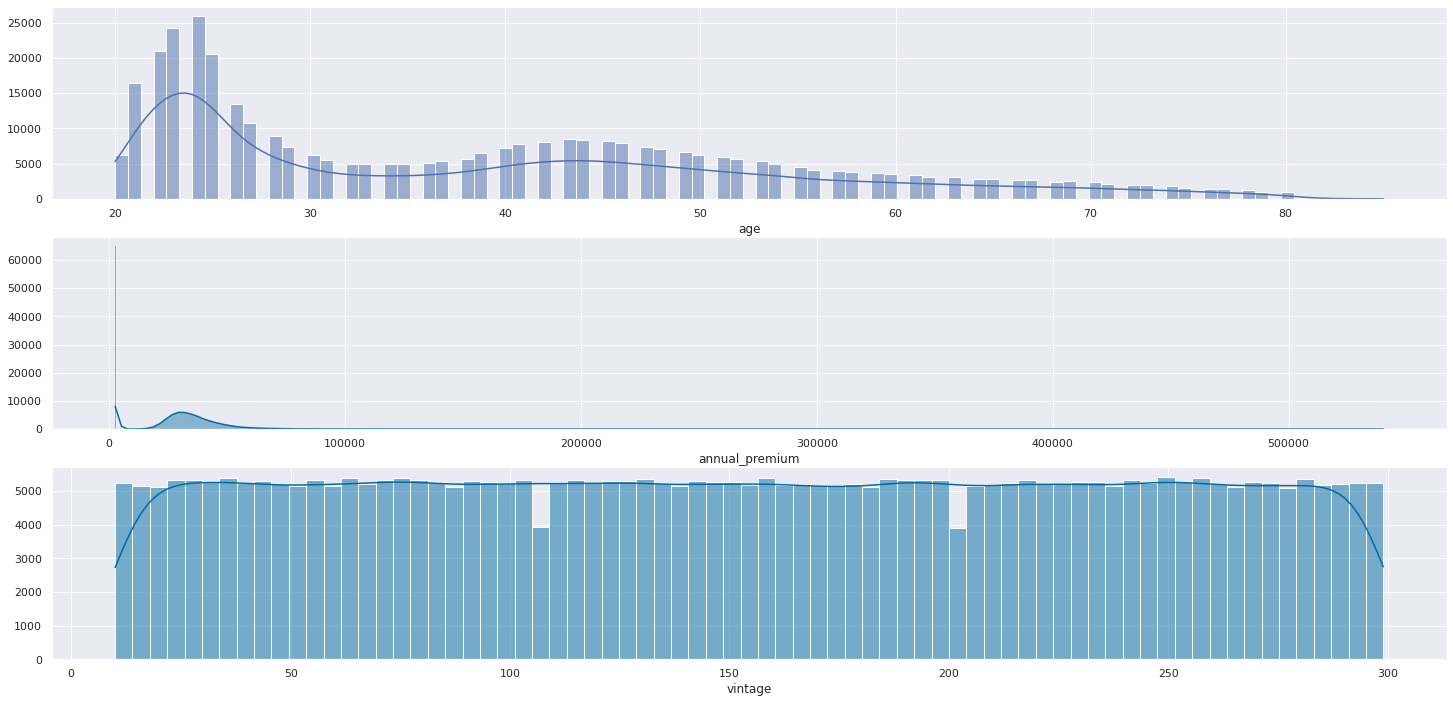

In [26]:
multiple_histplots(df1[['age', 'annual_premium', 'vintage']], 3, 1);

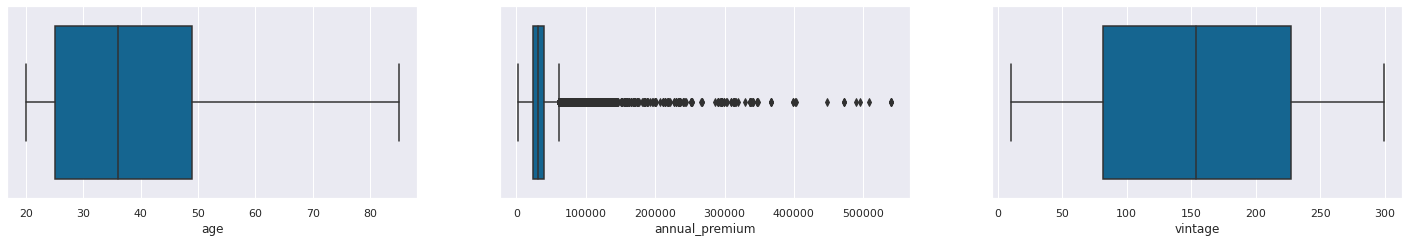

In [27]:
i = 1
for col in num_attributes:
    plt.subplot(3, 3, i)
    ax = sns.boxplot(data = num_attributes, x = col)
    i += 1

#### 1.6.2 Categorical Attributes

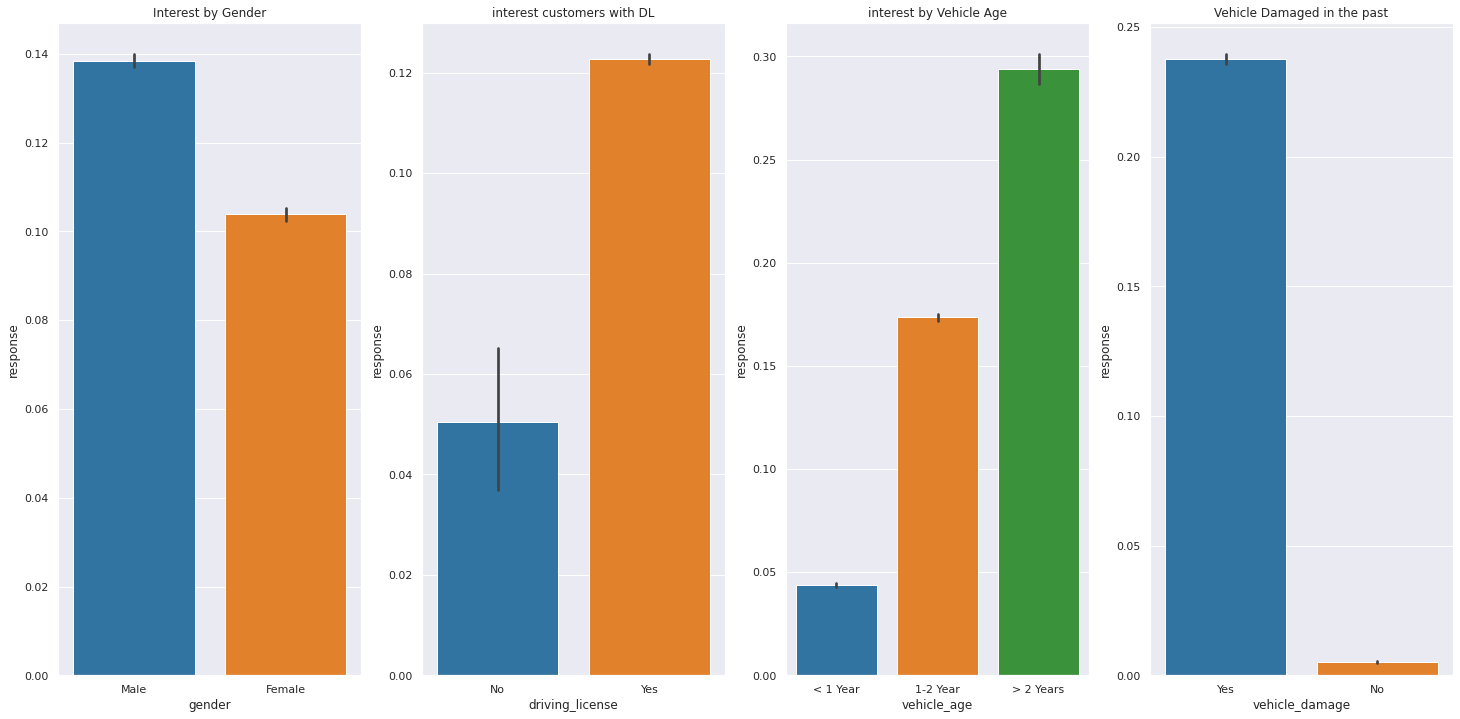

In [28]:
cat_attributes = df1[['gender', 'driving_license', 'vehicle_age', 'vehicle_damage', 'previously_insured', 'response']]

plt.subplot(1, 4, 1)
sns.barplot(x = 'gender', y = 'response', data = cat_attributes, palette = 'tab10')
plt.title('Interest by Gender');

plt.subplot(1, 4, 2)
sns.barplot(x = 'driving_license', y = 'response', data = cat_attributes, palette = 'tab10')
plt.xticks([0,1],['No','Yes']);
plt.title('interest customers with DL');

plt.subplot(1, 4, 3)
sns.barplot(x = 'vehicle_age', y = 'response', data = cat_attributes, palette = 'tab10')
plt.title('interest by Vehicle Age');

plt.subplot(1, 4, 4)
sns.barplot(x = 'vehicle_damage', y = 'response', data = cat_attributes, palette = 'tab10')
plt.title('Vehicle Damaged in the past');

##### 1.6.2.1 Gender

In [29]:
categorical_metrics(cat_attributes, 'gender')

,absolute,percent %
Male,206089,54.076
Female,175020,45.924


##### 1.6.2.2 Driving License

In [30]:
categorical_metrics(cat_attributes, 'driving_license')

,absolute,percent %
1,380297,99.787
0,812,0.213


##### 1.6.2.3 Vehicle Age

In [33]:
categorical_metrics(cat_attributes, 'vehicle_age')

,absolute,percent %
1-2 Year,200316,52.561
< 1 Year,164786,43.239
> 2 Years,16007,4.200


##### 1.6.2.4 Vehicle Damage

In [34]:
categorical_metrics(cat_attributes, 'vehicle_damage')

,absolute,percent %
Yes,192413,50.488
No,188696,49.512


##### 1.6.2.5 Previously Insured

In [35]:
categorical_metrics(cat_attributes, 'previously_insured')

,absolute,percent %
0,206481,54.179
1,174628,45.821


##### 1.6.2.6 Target

In [36]:
categorical_metrics(cat_attributes, 'response')

,absolute,percent %
0,334399,87.744
1,46710,12.256


Only 12.256% of the clients shows interest in vehicle insurance

### 1.7 Data Filtering

#### 1.7.1 Rows

- `Annual_premium` is the only feature with possible outliers, these high values ​​appear to be a characteristic of the business, so they cannot be removed. 
- Only 41 customers without `Driving License` demonstrated interest in car insurance, considering this dataset with 381.109 people, this value is insignificant, however, this information could be relevant in the ML modelling, so I will keep this customers.

in this database, there is no need for row filtering.

#### 1.7.2 Columns

in this database, there is no need for columns filtering, all the features are relevant in this bussiness problem.

### 1.8 Save State

In [37]:
df1.to_pickle(homepath + 'data/processed/df1.pkl')


## 2. FEATURE ENGINEERING

- **Tasks**
    - Split Data
    - Features Creatrion

### 2.1 Split Data


In [38]:
df_total = pd.read_pickle(homepath + 'data/processed/df1.pkl')

# Train -> 70%
# Test -> 20%
# Validation -> 10%
x_train, x_test = train_test_split(df_total , test_size = 0.2, random_state = seed)

# if train = 80% x dataset, then val = 0.1/0.8 = 0.125
# 0.125 x 0.8 = 0.1
x_train, x_val = train_test_split(x_train, test_size = 0.125, random_state = seed)

### 2.2 Feature Creation

`insurance_age`: According [Forbes Advisor](https://www.forbes.com/advisor/car-insurance/rates-age-and-gender/), age and gender are the factors with the greatest impact on the price of insurance, with age being the most relevant factor. The high car insurance rates that younger drivers pay start to go down at age 25 and the best rates are between 50s and early 60 years if the driver has a good record and start to rise again around 65. The main factors are the lack of experience in driving, greater impulsiveness, alcohol use, distractive driving and high speed for young people and greater likelihood of illness and risk of being injured or killed in a car crash in older drivers. After all this explanation, I propose this feature, with a scale from 1 to 5, 1 being the smallest weight in the insurance value and 5 being the biggest cost;

`vehicle_age`: just changing the description for a snakecase type;

`premium_per_vintage`: The highest value of the `vintage` is 299 days, approximately 10 months, as the `annual_premium` is the cost per year, it's possible to create a relation between these features if consider the amount of time the customer is associated with the database;

`premium_per_age`: Just a relation between the price and the customer age.

In [39]:
for dataframe in [x_train, x_test, x_val]:
    # vehicle_age
    dataframe['vehicle_age'] = dataframe['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 
                                                            'between_1_2_year' if x == '1-2 Year' else 
                                                            'below_1_year')
    
    # premium_per_vintage
    dataframe['premium_per_vintage'] = dataframe['annual_premium']/dataframe['vintage']
    
    # insurance age
    dataframe['insurance_age'] = dataframe['age'].apply(lambda x: 5 if (x >= 20 and x <= 25) else
                                                      3 if (x >= 26 and x <= 35) else
                                                      2 if (x >= 36 and x < 50) else
                                                      1 if (x >= 50 and x < 65) else
                                                      4)

# premium_per_age
df_premium_age_train, df_premium_age_test, df_premium_age_val = [dataframe.loc[:, ['age', 'annual_premium']].groupby('age').mean().reset_index() for dataframe in [x_train, x_test, x_val]]
df_premium_age_train.columns = ['age', 'premium_per_age']
df_premium_age_test.columns = ['age', 'premium_per_age']
df_premium_age_val.columns = ['age', 'premium_per_age']
x_train = pd.merge(x_train, df_premium_age_train, on = 'age', how = 'left')
x_test = pd.merge(x_test, df_premium_age_test, on = 'age', how = 'left')
x_val = pd.merge(x_val, df_premium_age_val, on = 'age', how = 'left')

In [40]:
df2 = pd.concat([x_train, x_test, x_val], ignore_index = True)

### 2.3 Save State

In [41]:
df2.to_pickle(homepath + 'data/processed/df2.pkl')
x_train.to_pickle(homepath + 'data/processed/x_train.pkl')
x_test.to_pickle(homepath + 'data/processed/x_test.pkl')
x_val.to_pickle(homepath + 'data/processed/x_val.pkl')

## 3. EXPLORATORY DATA ANALYSIS

### 3.1 Dataset Checkpoint


In [97]:
df3 = pd.read_pickle(homepath + 'data/processed/df2.pkl')

eda_encoding = {0: 'No', 1: 'Yes'}

for col in ['previously_insured', 'driving_license']:
    df3[col] = df3[col].map(eda_encoding)

### 3.2 EDA Report

In [98]:
from dataprep.eda import create_report, plot, plot_diff

In [99]:
report = create_report(df3, title = 'Insurance Cross Sell');
report.save(homepath + 'reports/report.html');
report.show_browser();

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2696 [00:00<?, ?it/s]

Report has been saved to /home/guttofranca/Repos/pa004_health_insurance_cross_sell/health_insurance_cross-sell/reports/report.html!


### 3.3 Univariate Analysis

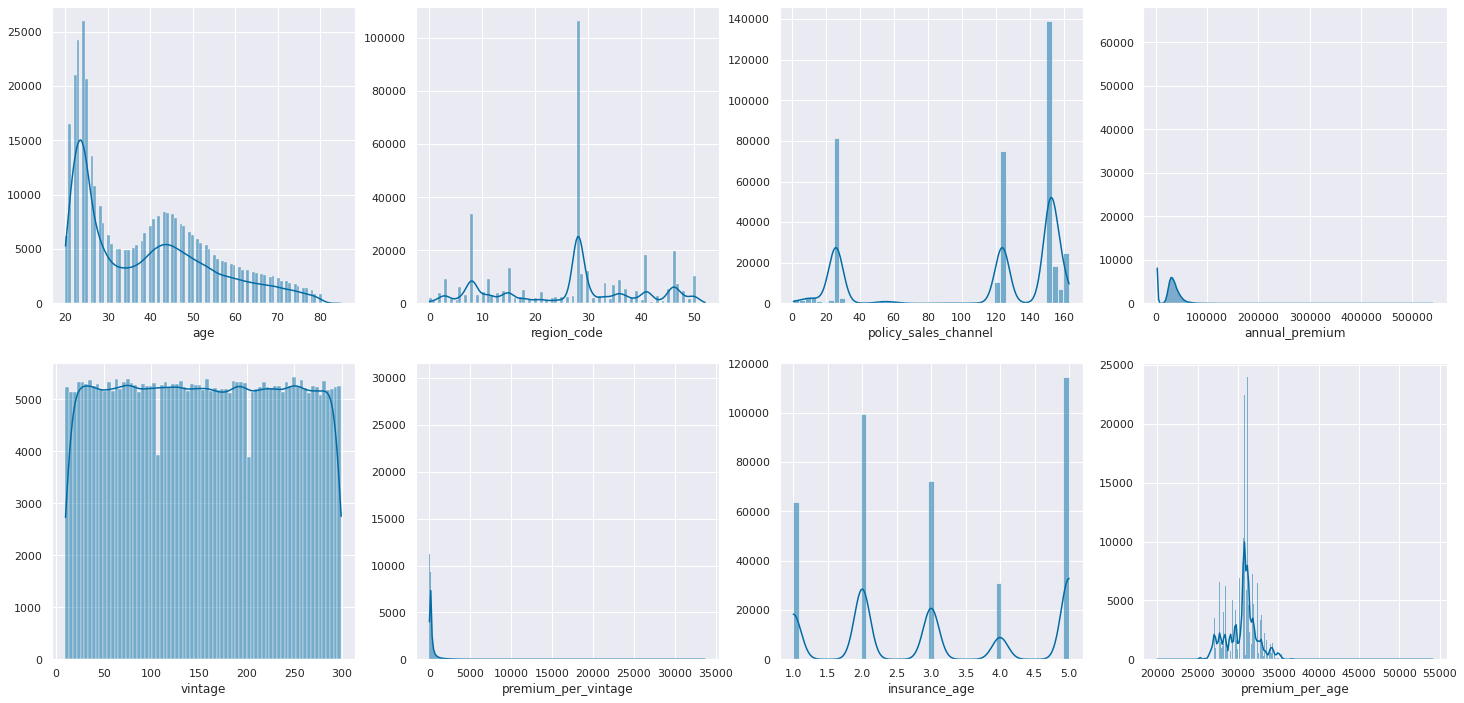

In [105]:
univariate_numerical = df3.select_dtypes(include=['int64', 'float64'])
cols_drop = ['id', 'response']
univariate_numerical = univariate_numerical.drop(columns = cols_drop)
univariate_numerical.columns

multiple_histplots(univariate_numerical, 2, 4);

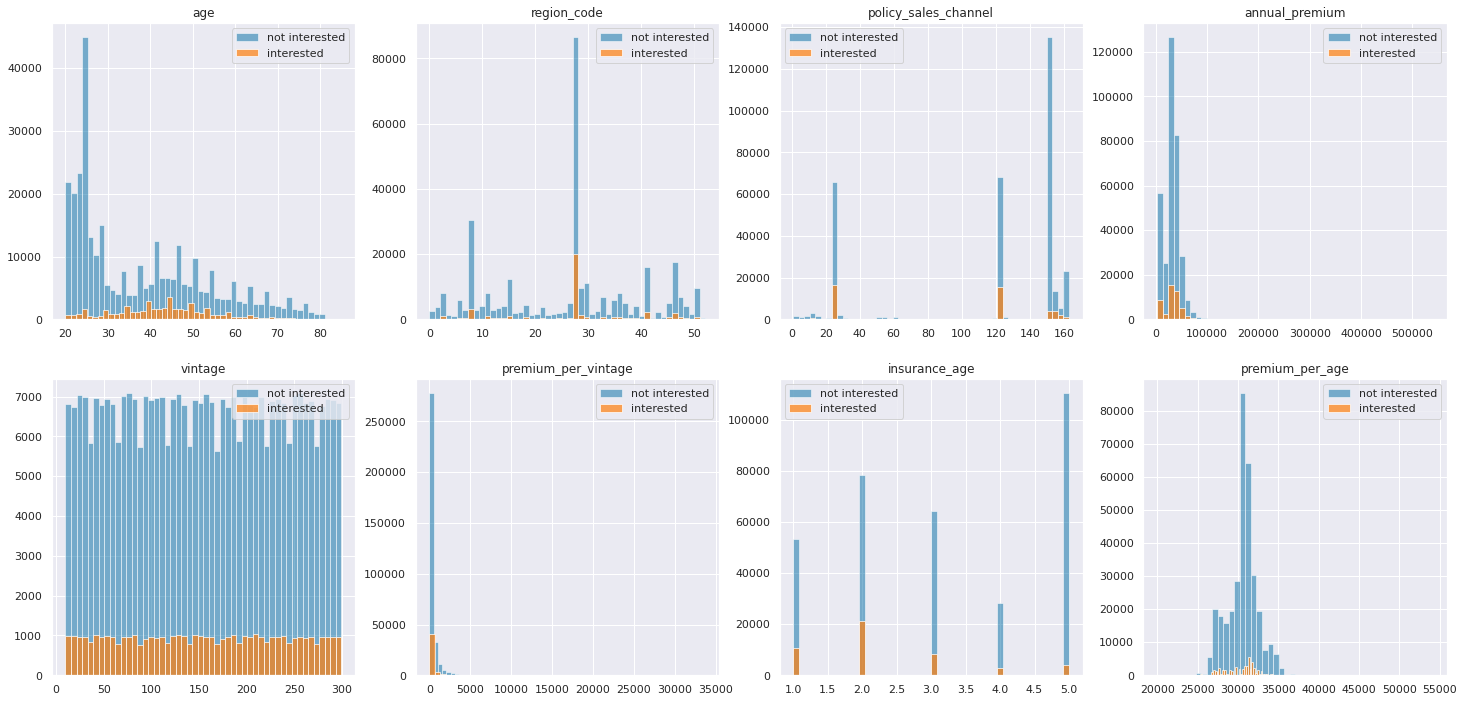

In [103]:
# creating two datasets, one with interested and other with not interested hue
numerical_interested = univariate_numerical[univariate_numerical['response'] == 1]
numerical_not_interested = univariate_numerical[univariate_numerical['response'] == 0]

# creating subplots
fig, ax = plt.subplots(2, 4)

plot_with_target(numerical_not_interested, numerical_interested,
                 'age', 0, 0, 'not interested', 'interested');

plot_with_target(numerical_not_interested, numerical_interested,
                 'region_code', 0, 1, 'not interested', 'interested');

plot_with_target(numerical_not_interested, numerical_interested,
                 'policy_sales_channel', 0, 2, 'not interested', 'interested');

plot_with_target(numerical_not_interested, numerical_interested,
                 'annual_premium', 0, 3, 'not interested', 'interested');

plot_with_target(numerical_not_interested, numerical_interested,
                 'vintage', 1, 0, 'not interested', 'interested');

plot_with_target(numerical_not_interested, numerical_interested,
                 'premium_per_vintage', 1, 1, 'not interested', 'interested');

plot_with_target(numerical_not_interested, numerical_interested,
                 'insurance_age', 1, 2, 'not interested', 'interested');

plot_with_target(numerical_not_interested, numerical_interested,
                 'premium_per_age', 1, 3, 'not interested', 'interested');

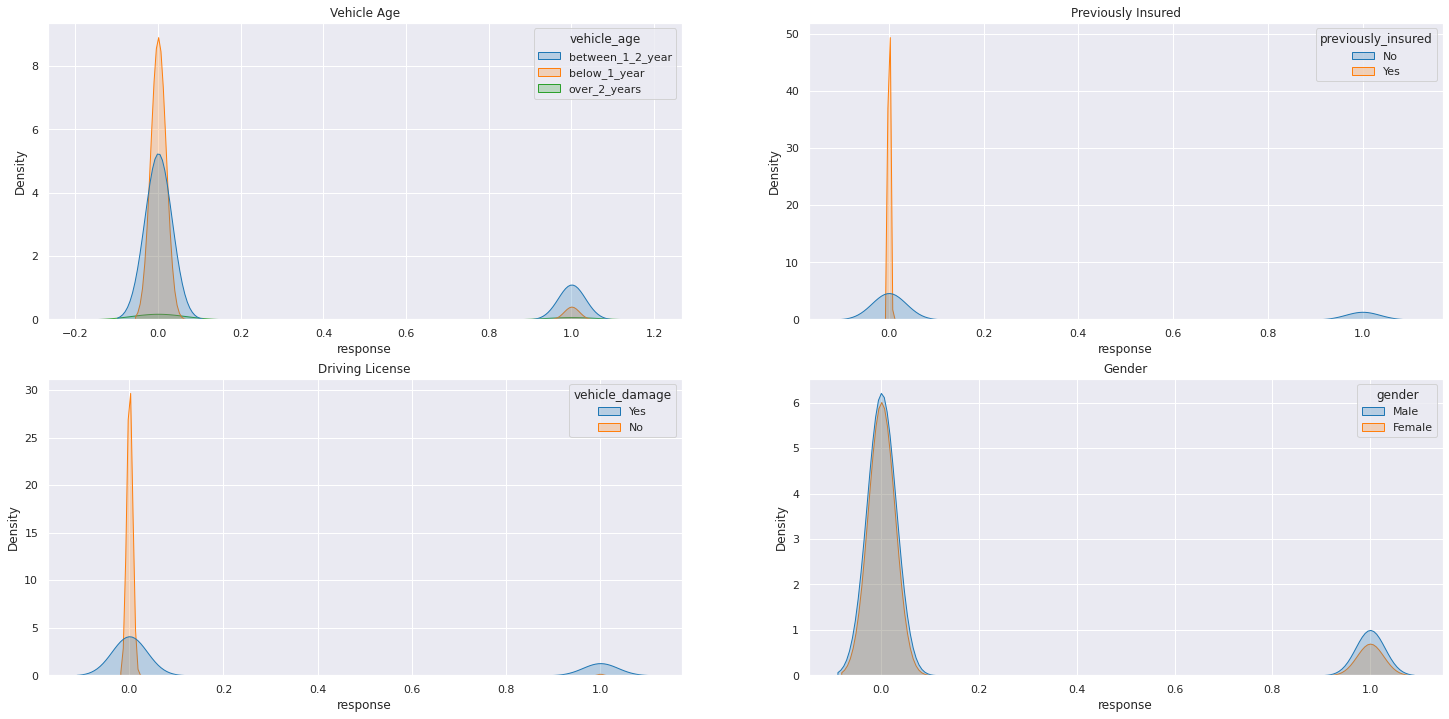

In [102]:
cat_target = df3[['previously_insured', 'driving_license', 'gender', 'vehicle_age', 'vehicle_damage', 'response']]

plt.subplot(2, 2, 1)
sns.kdeplot(x = 'response', hue = 'vehicle_age', data = cat_target, shade = True, palette = 'tab10')
plt.title('Vehicle Age');

plt.subplot(2, 2, 2)
sns.kdeplot(x = 'response', hue = 'previously_insured', data = cat_target, shade = True, palette = 'tab10')
plt.title('Previously Insured');

plt.subplot(2, 2, 3)
sns.kdeplot(x = 'response', hue = 'vehicle_damage', data = cat_target, shade = True, palette = 'tab10')
plt.title('Driving License');

plt.subplot(2, 2, 4)
sns.kdeplot(x = 'response', hue = 'gender', data = cat_target, shade = True, palette = 'tab10')
plt.title('Gender');

### 3.4 Bivariate Analysis

#### 3.4.1 Pairplot

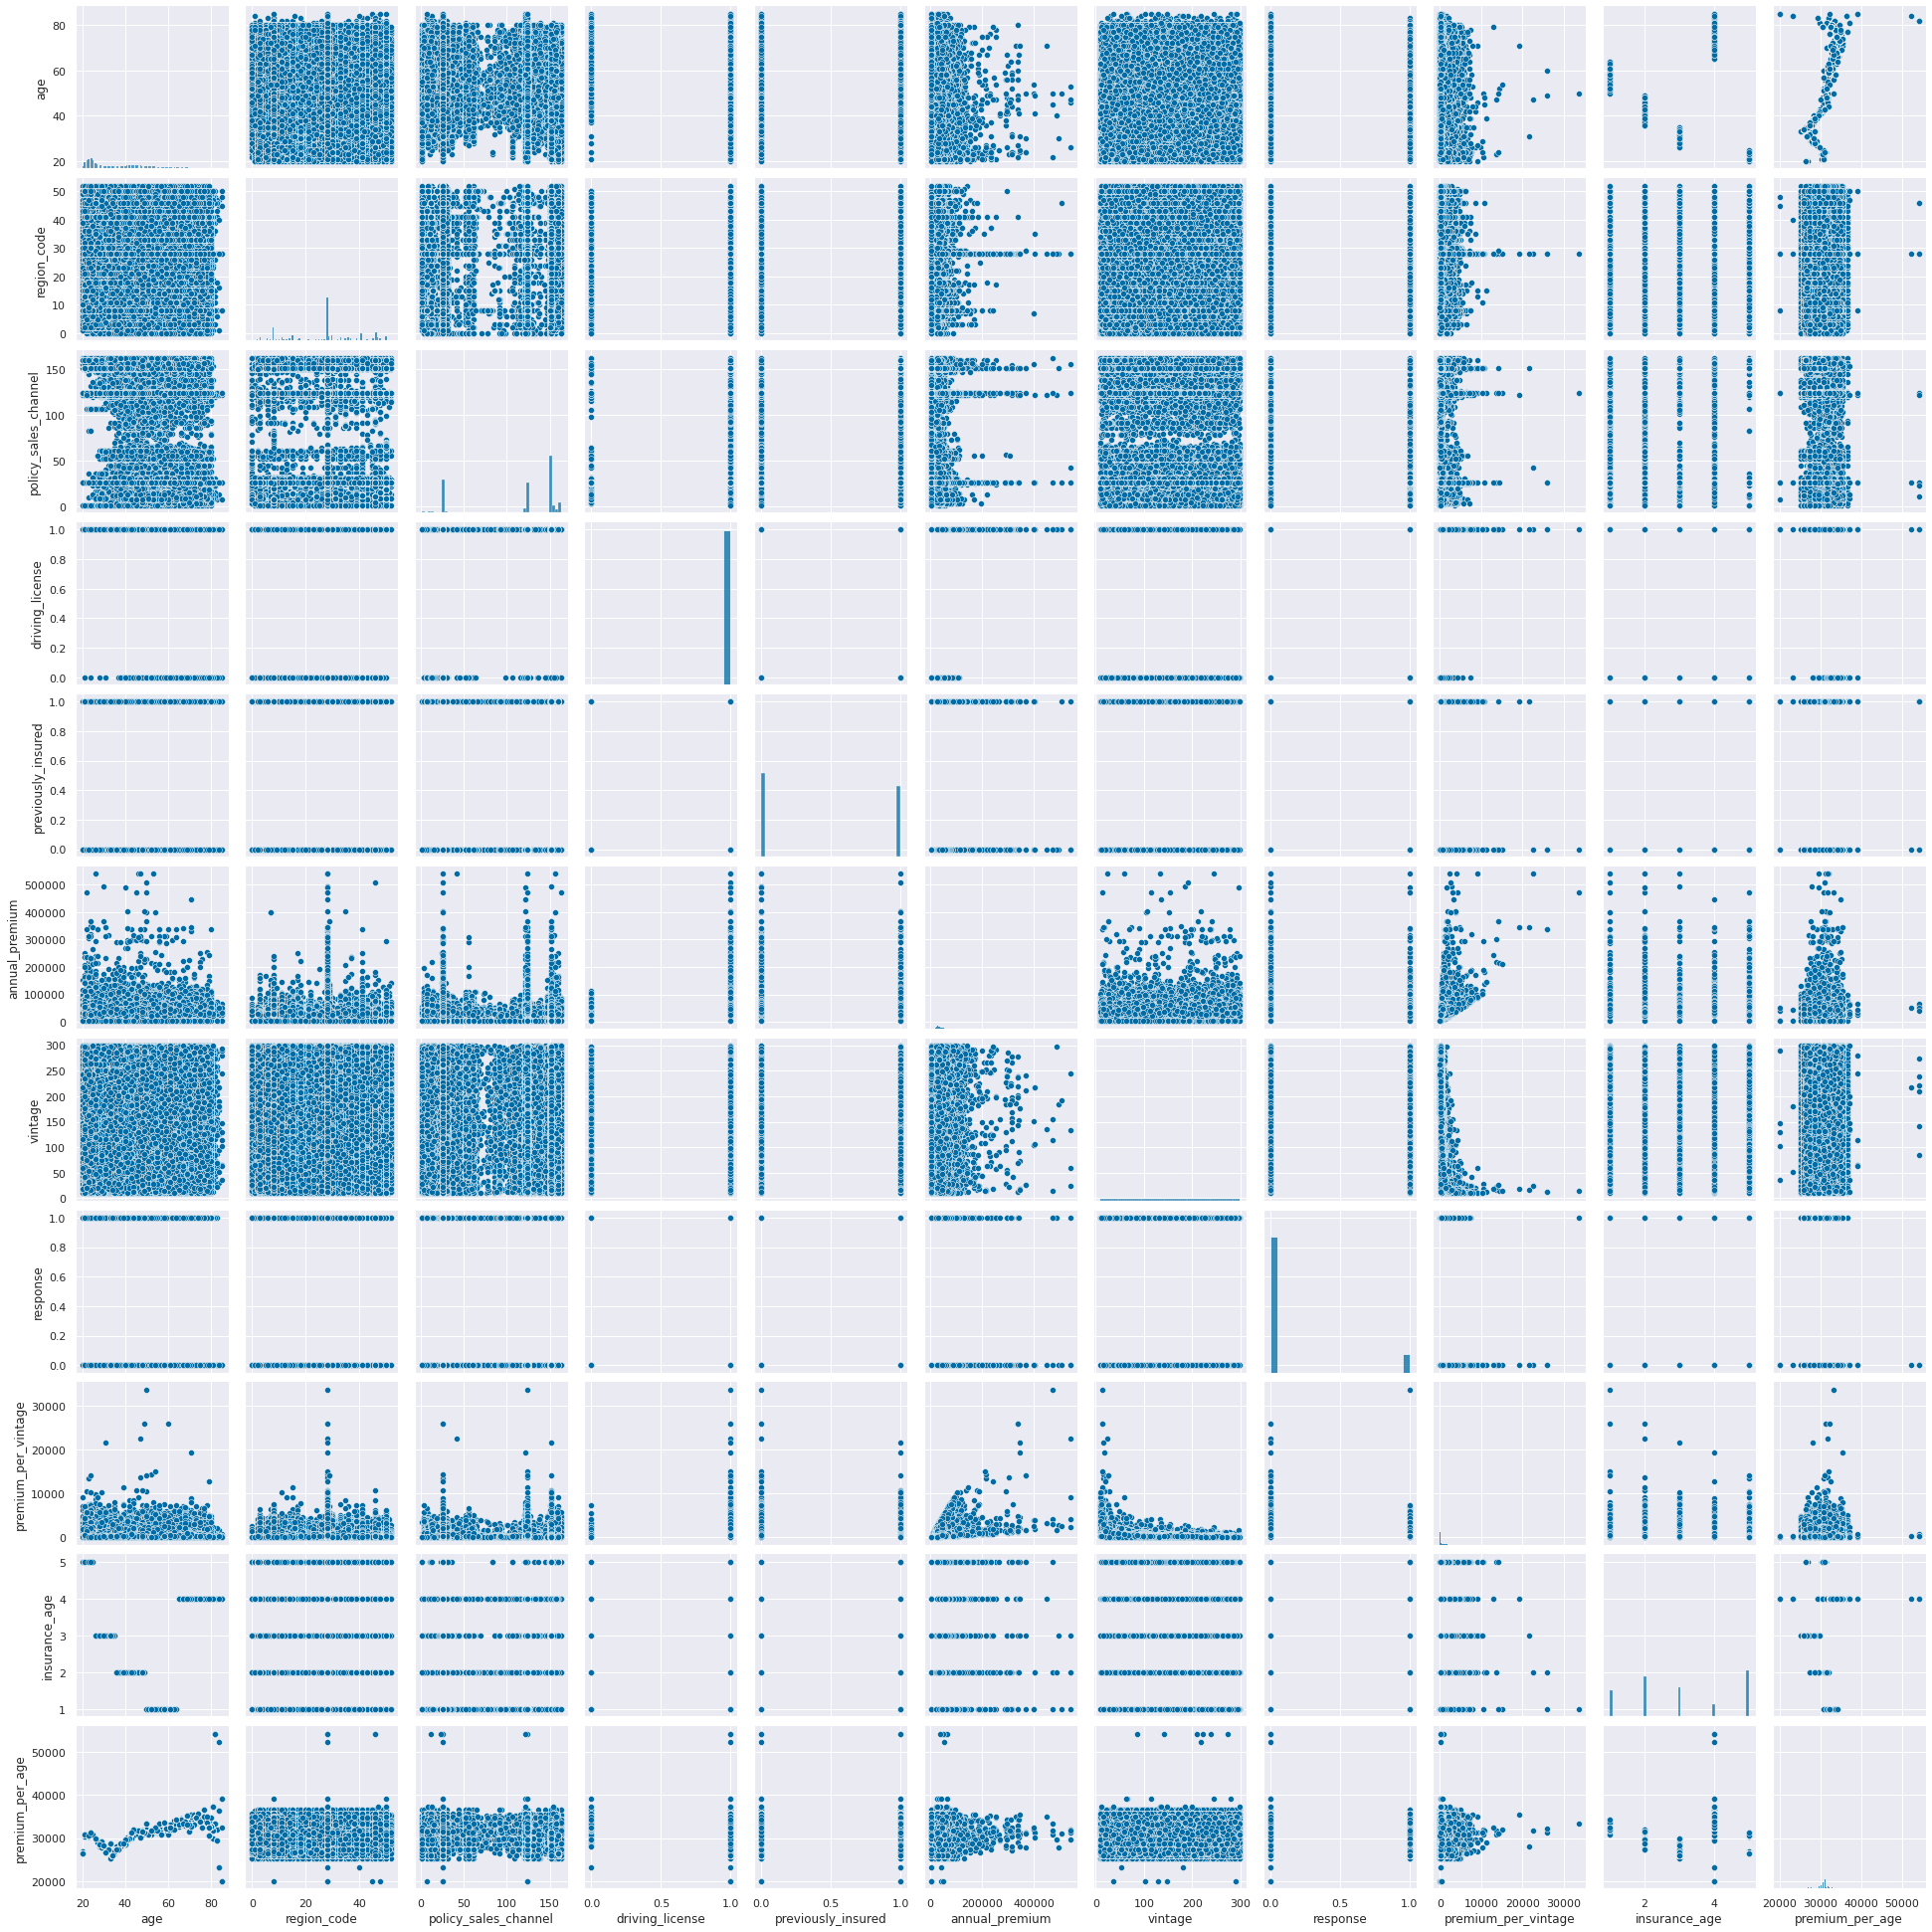

In [ ]:
df3_pairplot = df3.drop('id', axis = 1)
sns.pairplot(df3_pairplot);

#### H1. Men have more than 51% vehicle damages in the past.
**True** Vehicle Damage with men represent 58.6% of the total.

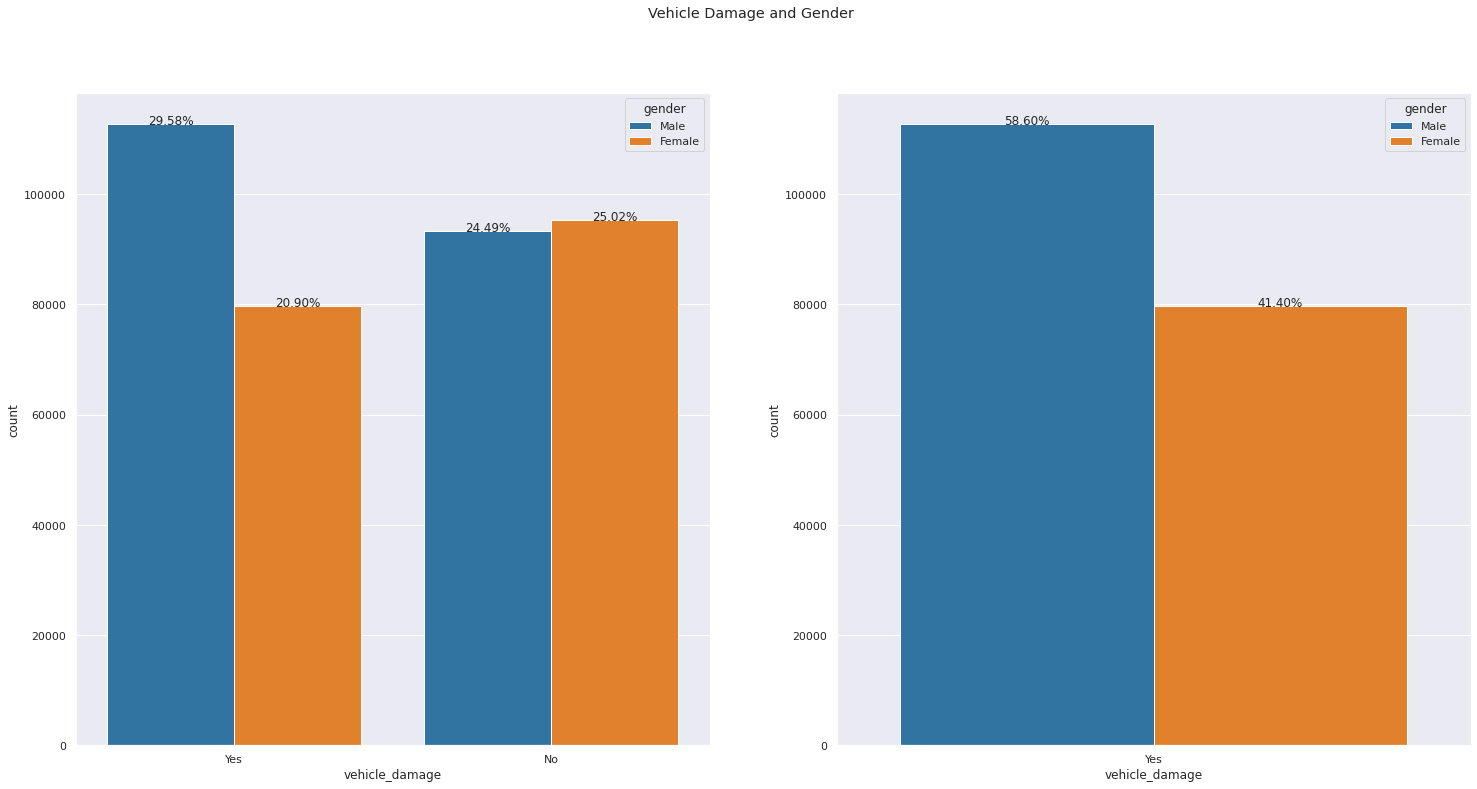

In [107]:
h1_aux = df3[['gender', 'vehicle_damage']]
h1_aux_2 = h1_aux[h1_aux['vehicle_damage'] == 'Yes']

# creating subplots
fig, ax = plt.subplots()
fig.suptitle('Vehicle Damage and Gender')

plt.subplot(1, 2, 1)
ax = sns.countplot(x = 'vehicle_damage', hue = 'gender', data = h1_aux, palette = 'tab10')
percentage(ax, h1_aux)

plt.subplot(1, 2, 2)
ax2 = sns.countplot(x = 'vehicle_damage', hue = 'gender', data = h1_aux_2, palette = 'tab10')
percentage(ax2, h1_aux_2)

#### H2. Customers with more than 65 years has the highest annual premium
**True** Customers with more than 65 year pay more, especially in 80's.

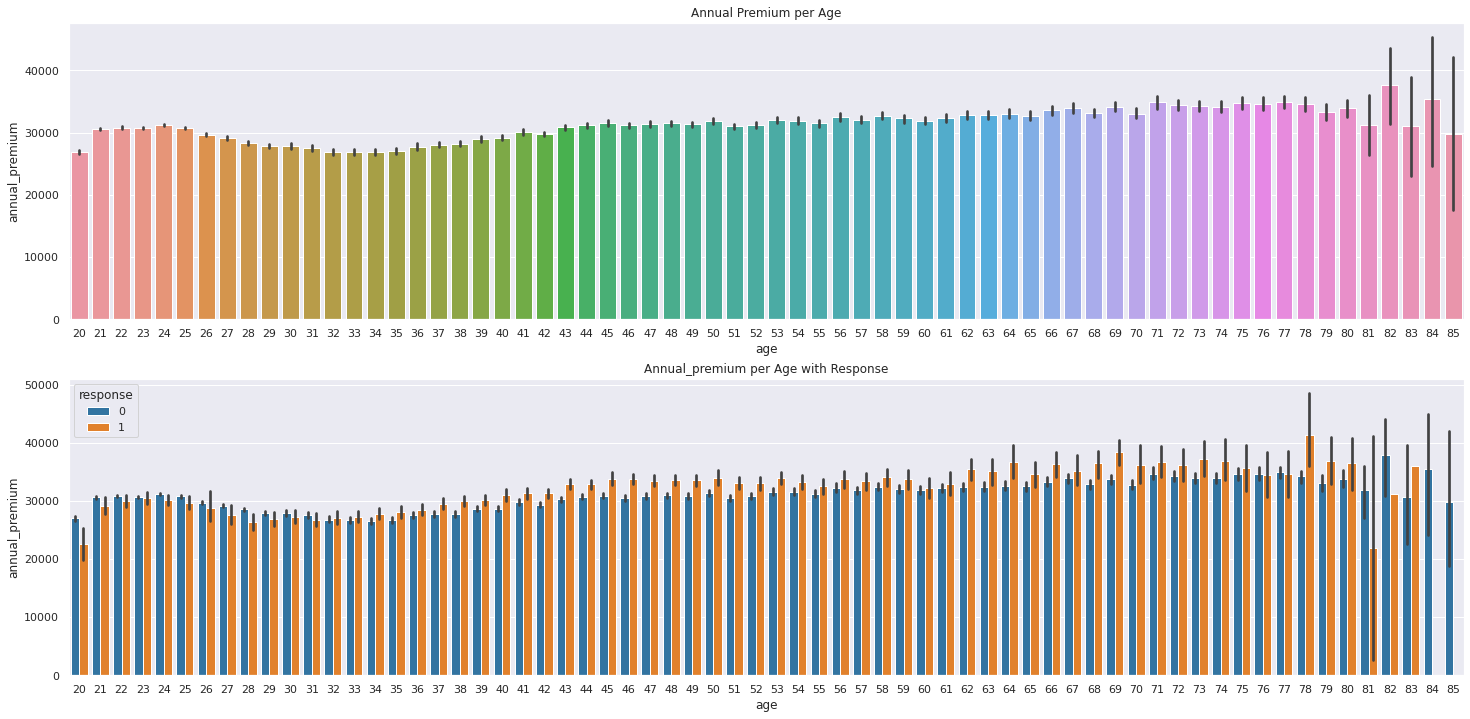

In [108]:
h2_aux = df3[['age', 'annual_premium', 'response']]

# creating subplots
plt.subplot(2, 1, 1)
ax = sns.barplot(y = 'annual_premium', x = 'age', data = h2_aux)
ax.set_title('Annual Premium per Age');

plt.subplot(2, 1, 2)
ax2 = sns.barplot(y = 'annual_premium', x = 'age', data = h2_aux, palette = 'tab10', hue = 'response')
ax2.set_title('Annual_premium per Age with Response');

#### H3. More than 80% of the customers who already have/had a car insurance are not interested in the product.
**True** 99.91% of the customers who already have/had a car insurance are not interested in the product.

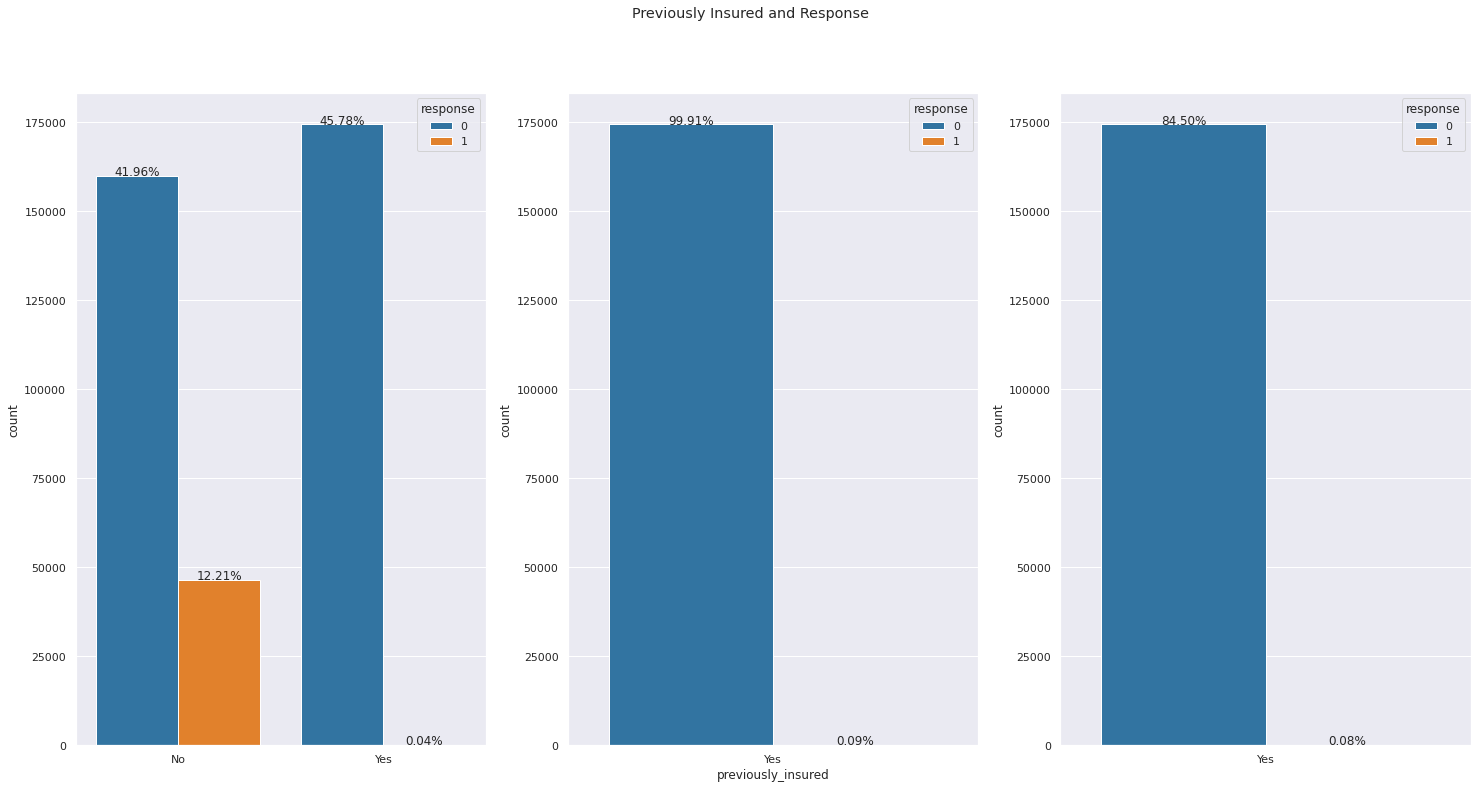

In [109]:
h3_aux = df3[['previously_insured', 'response']]
h3_aux_2 = h3_aux[h3_aux['previously_insured'] == 'Yes']
h3_aux_3 = h3_aux[h3_aux['previously_insured'] == 'No']

# creating subplots
fig, ax = plt.subplots()
fig.suptitle('Previously Insured and Response')

plt.subplot(1, 3, 1)
ax = sns.countplot(x = 'previously_insured', hue = 'response', data = h3_aux, palette = 'tab10')
percentage(ax, h3_aux)
ax.set_xlabel('')

plt.subplot(1, 3, 2)
ax2 = sns.countplot(x = 'previously_insured', hue = 'response', data = h3_aux_2, palette = 'tab10')
percentage(ax2, h3_aux_2)

plt.subplot(1, 3, 3)
ax3 = sns.countplot(x = 'previously_insured', hue = 'response', data = h3_aux_2, palette = 'tab10')
percentage(ax3, h3_aux_3)
ax3.set_xlabel('');

#### H4. Women have more interest in car insurance than men.
**False** Men have more interest but women have/had more vehicle insurance, even if the difference is very small.

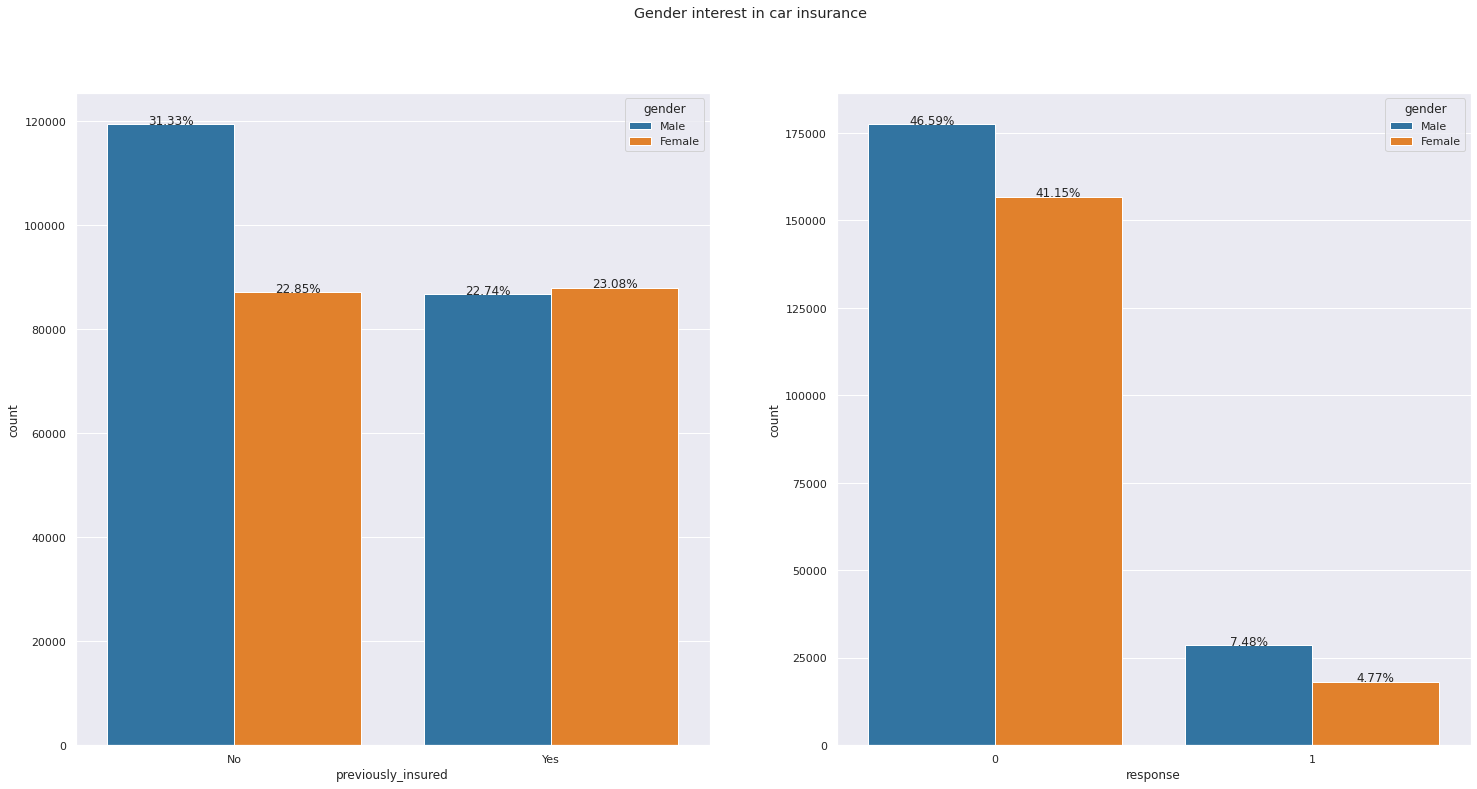

In [111]:
h4_aux = df3[['gender', 'previously_insured', 'response']]

# creating subplots
fig, ax = plt.subplots()
fig.suptitle('Gender interest in car insurance')

plt.subplot(1, 2, 1)

ax = sns.countplot(x = 'previously_insured', hue = 'gender', data = h4_aux, palette = 'tab10')
percentage(ax, h4_aux)


plt.subplot(1, 2, 2)
ax2 = sns.countplot(x = 'response', hue = 'gender', data = h4_aux, palette = 'tab10')
percentage(ax2, h4_aux)

#### H5. Customers after the 60's has more interest than young customers.
**False** Interested customers have between 35 and 55 years old.

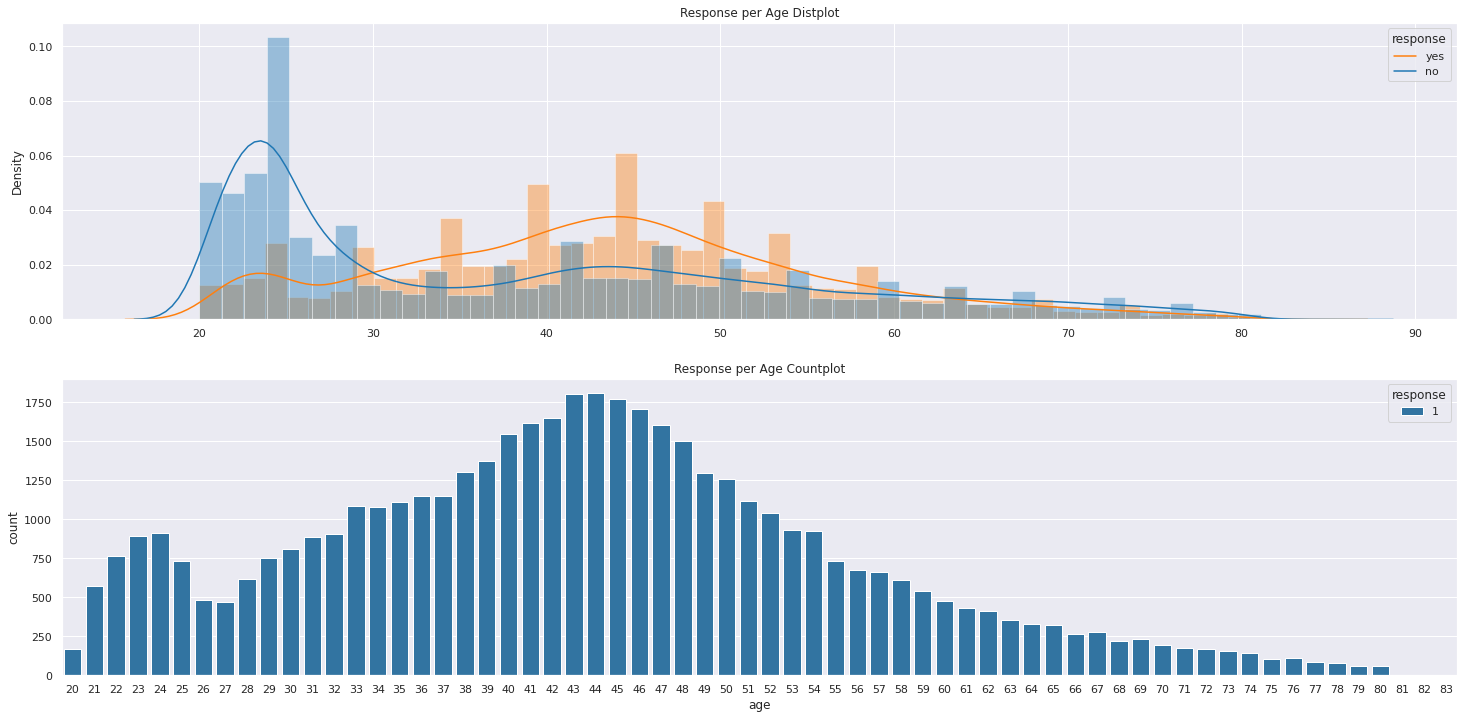

In [125]:
h5_aux = df3[['age', 'response']]
h5_aux_2 = h5_aux[h5_aux['response'] == 1]

plt.subplot(2, 1, 1)
ax = sns.distplot(h5_aux[h5_aux['response'] == 1]['age'], label = 'yes', color = '#FF7F0E')
ax = sns.distplot(h5_aux[h5_aux['response'] == 0]['age'], label = 'no', color = '#1F77B4')
plt.legend(['yes', 'no'], title = 'response')
ax.set_title('Response per Age Distplot')
ax.set_xlabel('')

plt.subplot(2, 1, 2)
ax2 = sns.countplot(x = 'age', data = h5_aux_2, palette = 'tab10', hue = 'response')
ax2.set_title('Response per Age Countplot');

#### H6. More than 80% of the interested customers in vehicle insurance already had their vehicle damaged in the past.
**True** 97.90% of the interested customers already had the vehicle damaged in the past.

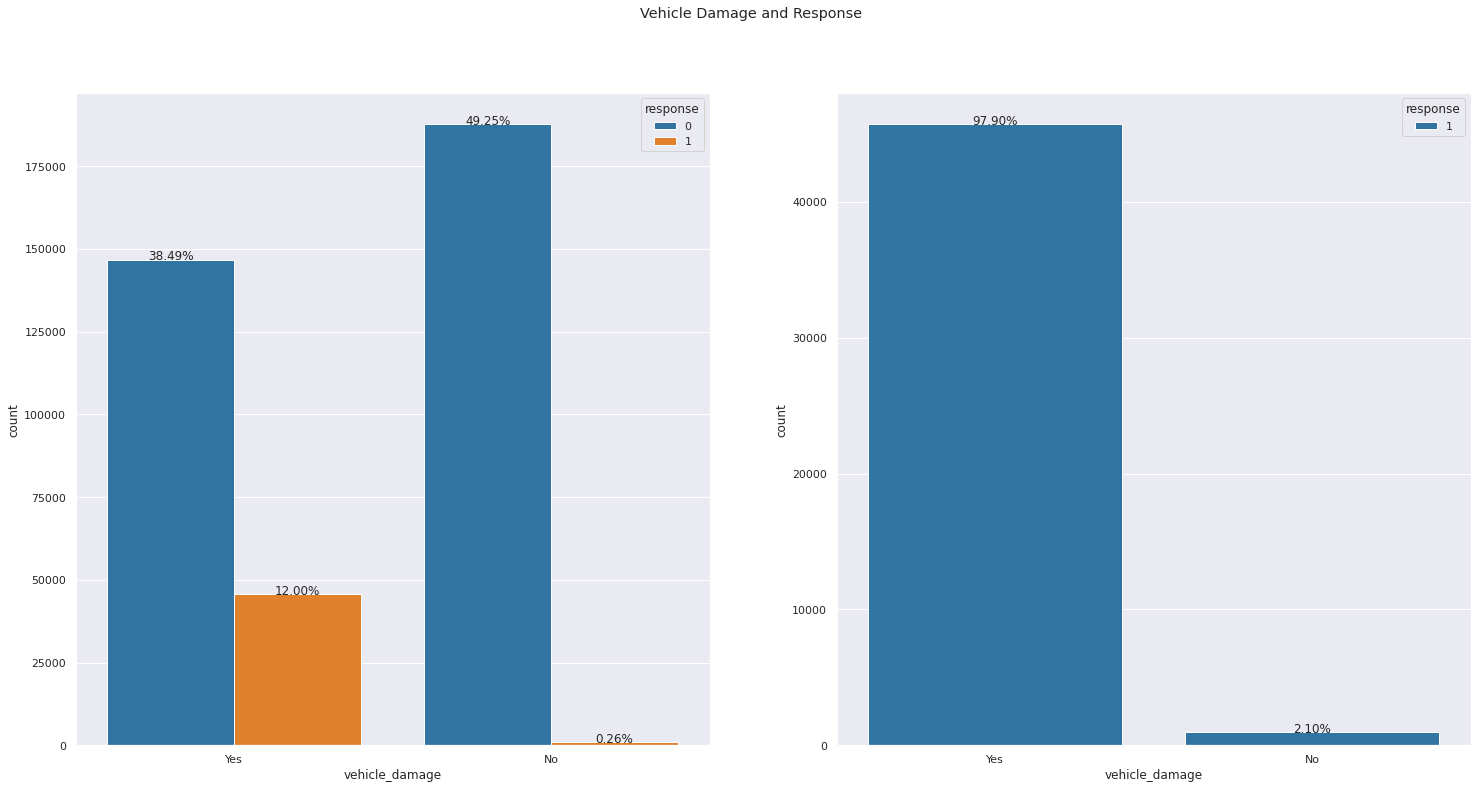

In [128]:
h6_aux = df3[['response', 'vehicle_damage']]
h6_aux_2 = h6_aux[h6_aux['response'] == 1]

# creating subplots
fig, ax = plt.subplots()
fig.suptitle('Vehicle Damage and Response')

plt.subplot(1, 2, 1)
ax = sns.countplot(x = 'vehicle_damage', hue = 'response', data = h6_aux, palette = 'tab10')
percentage(ax, h6_aux)

plt.subplot(1, 2, 2)
ax2 = sns.countplot(x = 'vehicle_damage', hue = 'response', data = h6_aux_2, palette = 'tab10')
percentage(ax2, h6_aux_2)

#### H7. More than 70% of interested customers have a vehicle for less than 1 year.
**False** Only 15.42% of the customer have interest. People with vehicles with age between 1-2 year have much more interest (74.52%)

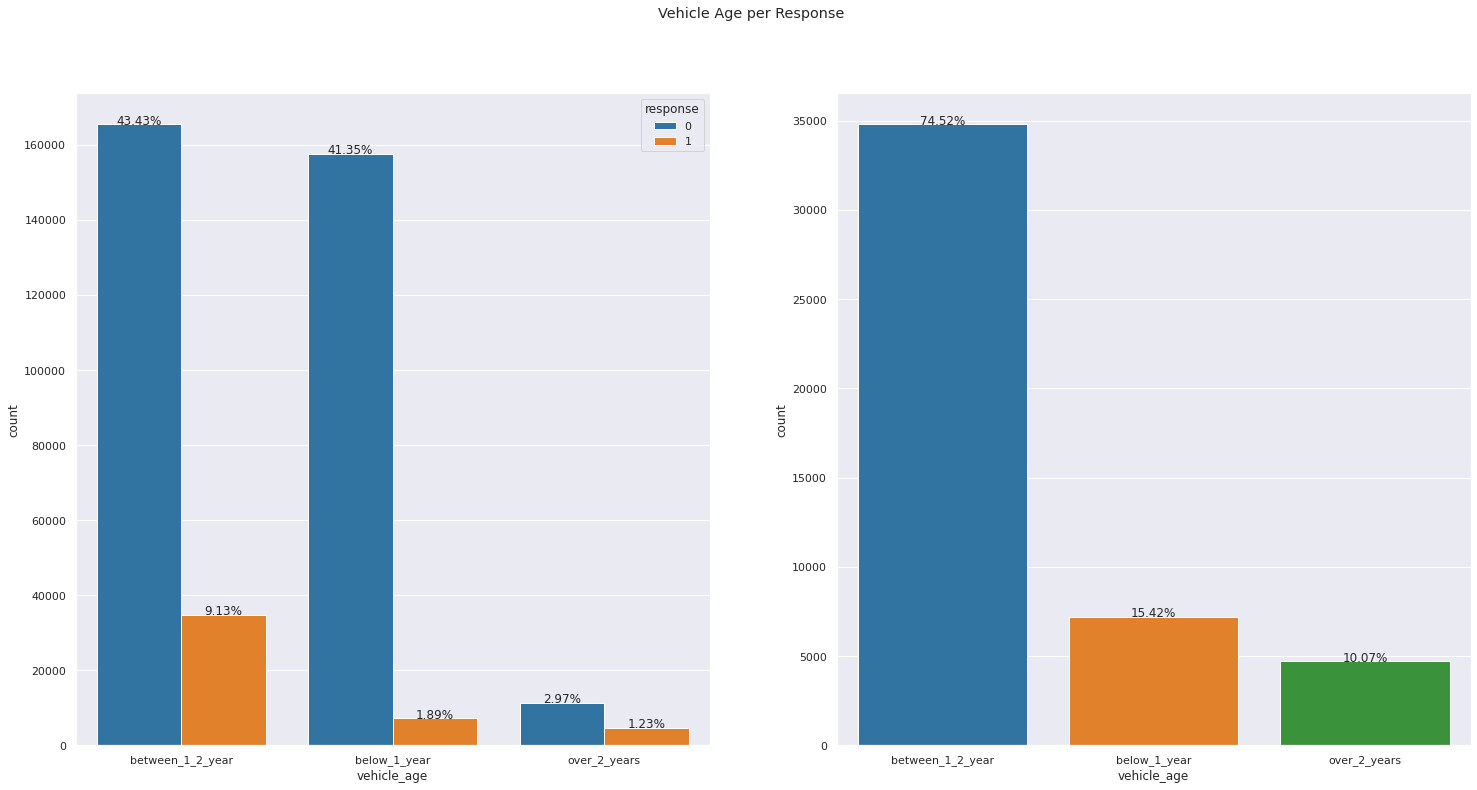

In [133]:
h7_aux = df3[['vehicle_age', 'response']]
h7_aux_2 = h7_aux[h7_aux['response'] == 1]

# creating subplots
fig, ax = plt.subplots()
fig.suptitle('Vehicle Age and Response')

plt.subplot(1, 2, 1)
ax2 = sns.countplot(x = 'vehicle_age', hue = 'response', data = h7_aux, palette = 'tab10')
percentage(ax2, h7_aux)

plt.subplot(1, 2, 2)
ax = sns.countplot(x = 'vehicle_age', data = h7_aux_2, palette = 'tab10')
percentage(ax, h7_aux_2)

#### H8. Customer that paid between $25000-$45000 last year represents more than half of the people interest in vehicle insurance.
**True** Customer that paid between $25000-$45000 represents 57.13% of the total interested customers.

In [136]:
df_annual_premium = df3[['annual_premium']]
annual_premium_result = numerical_metrics(df_annual_premium)
annual_premium_result

,Attributes,Min,Max,Range,Mean,Median,Q1,Q3,St deviation,Skewness,Kurtosis
0,annual_premium,2630.000,540165.000,537535.000,30564.390,31669.000,24405.000,39400.000,17213.132,1.766,34.005


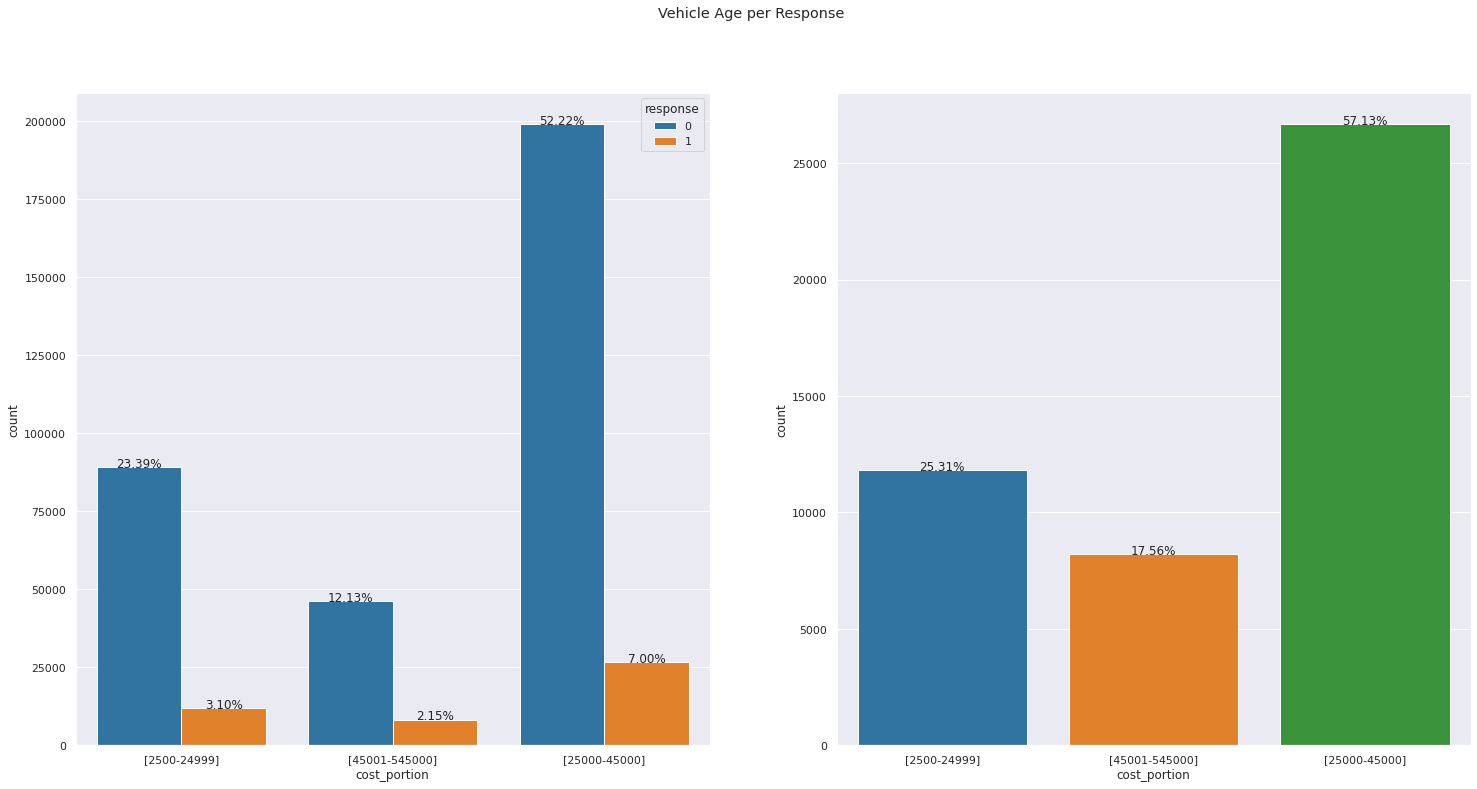

In [137]:
h8_aux = df3[['annual_premium', 'response']]
h8_aux['cost_portion'] = h8_aux['annual_premium'].apply(lambda x: '[$2500-$24999]' if x < 25000 else
                                                                  '[$25000-$45000]' if x >= 25000 and x <= 45000 else
                                                                  '[$45001-$545000]'
                                                        )

h8_aux_2 = h8_aux[h8_aux['response'] == 1]

# creating subplots
fig, ax = plt.subplots()
fig.suptitle('Annual Premium and Response')

plt.subplot(1, 2, 1)
ax2 = sns.countplot(x = 'cost_portion', hue = 'response', data = h8_aux, palette = 'tab10')
percentage(ax2, h8_aux)

plt.subplot(1, 2, 2)
ax = sns.countplot(x = 'cost_portion', data = h8_aux_2, palette = 'tab10')
percentage(ax, h8_aux_2)

#### H9. Customers with less time in the company has less interest in car insurace.
**False** The company's time is not related to the interest in insurance

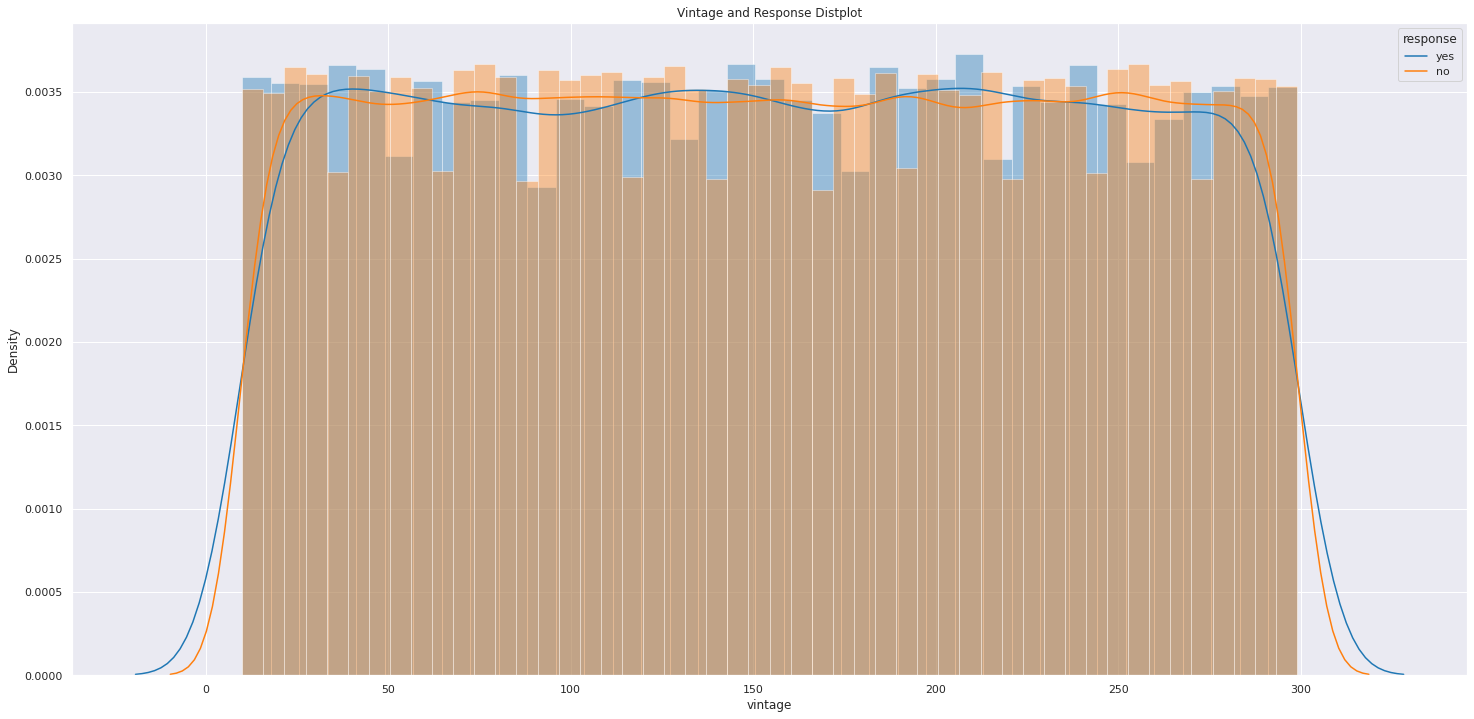

In [154]:
h9_aux = df3[df3['response'] == 1]['vintage']
h9_aux_2 = df3[df3['response'] == 0]['vintage']
ax = sns.distplot(h9_aux, color = '#1F77B4')
ax = sns.distplot(h9_aux_2, color = '#FF7F0E')
plt.legend(['yes', 'no'], title = 'response')
ax.set_title('Vintage and Response Distplot');

#### H10. Customers without driving license have no interest in car insurance.
**True** 94.95% of the customers without driving license have no interest in car insurance, that value corresponds to only 771 clients without interest and 41 with interest in car insurance.

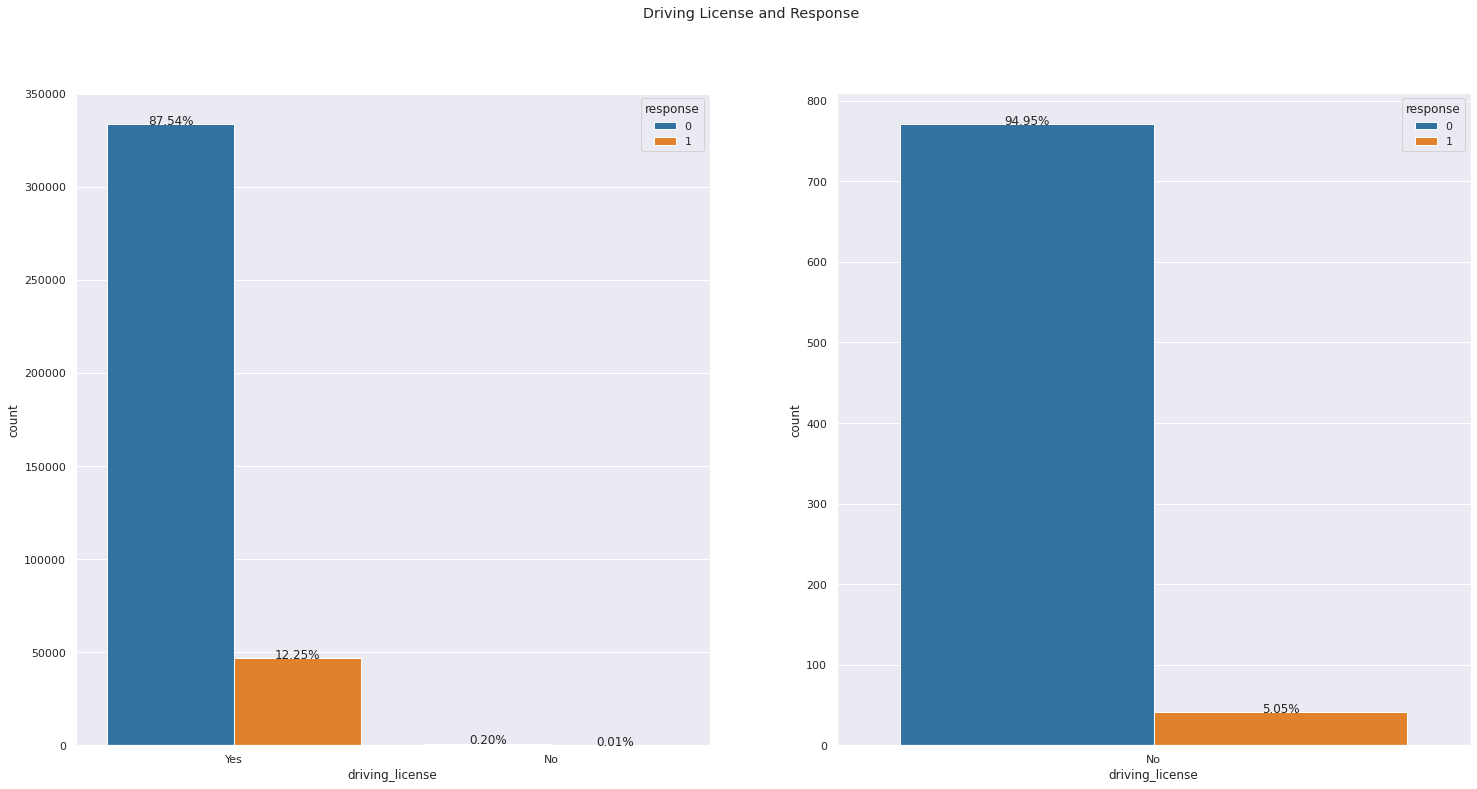

In [191]:
h10_aux = df3[['driving_license', 'response']]
h10_aux_2 = h10_aux[h10_aux['driving_license'] == 'No']
h10_aux_3 = h10_aux[h10_aux['driving_license'] == 'Yes']

# creating subplots
fig, ax = plt.subplots()
fig.suptitle('Driving License and Response')

plt.subplot(1, 2, 1)
ax2 = sns.countplot(x = 'driving_license', hue = 'response', data = h10_aux, palette = 'tab10')
percentage(ax2, h10_aux)

plt.subplot(1, 2, 2)
ax = sns.countplot(x = 'driving_license', hue = 'response', data = h10_aux_2, palette = 'tab10')
percentage(ax, h10_aux_2)

In [192]:
categorical_metrics(h10_aux_2, 'response')

,absolute,percent %
0,771,94.951
1,41,5.049


In [193]:
categorical_metrics(h10_aux_3, 'response')

,absolute,percent %
0,333628,87.728
1,46669,12.272


### 3.4 Multivariate Analysis

#### 3.4.1 Numerical Features

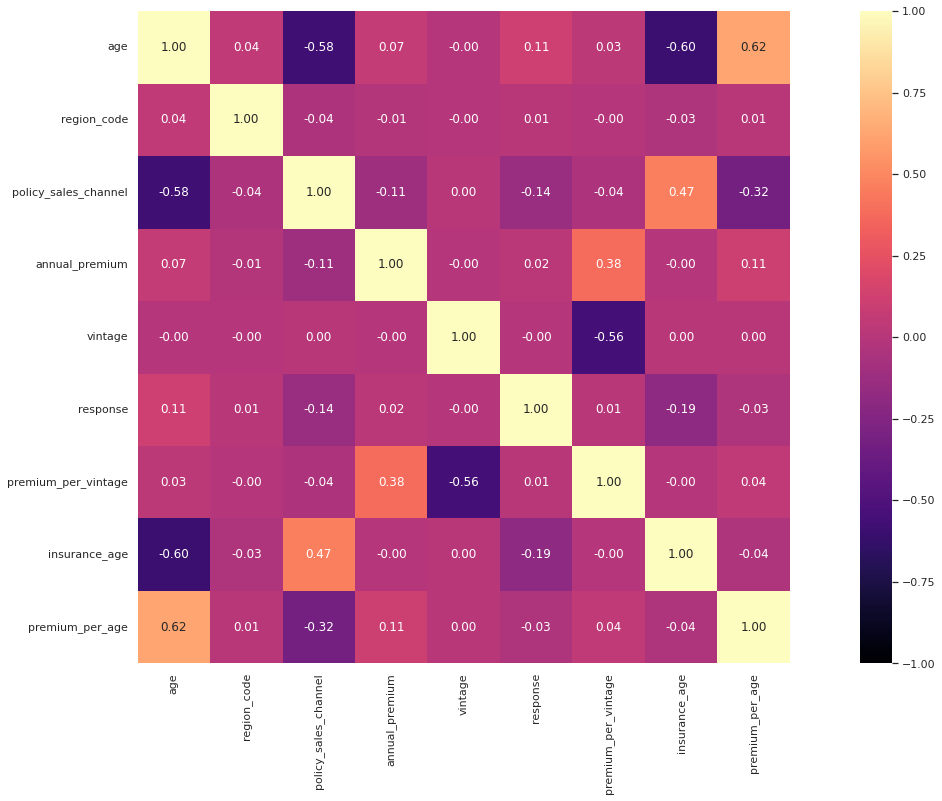

In [46]:
correlation_matrix(df3, cols_drop,'pearson');

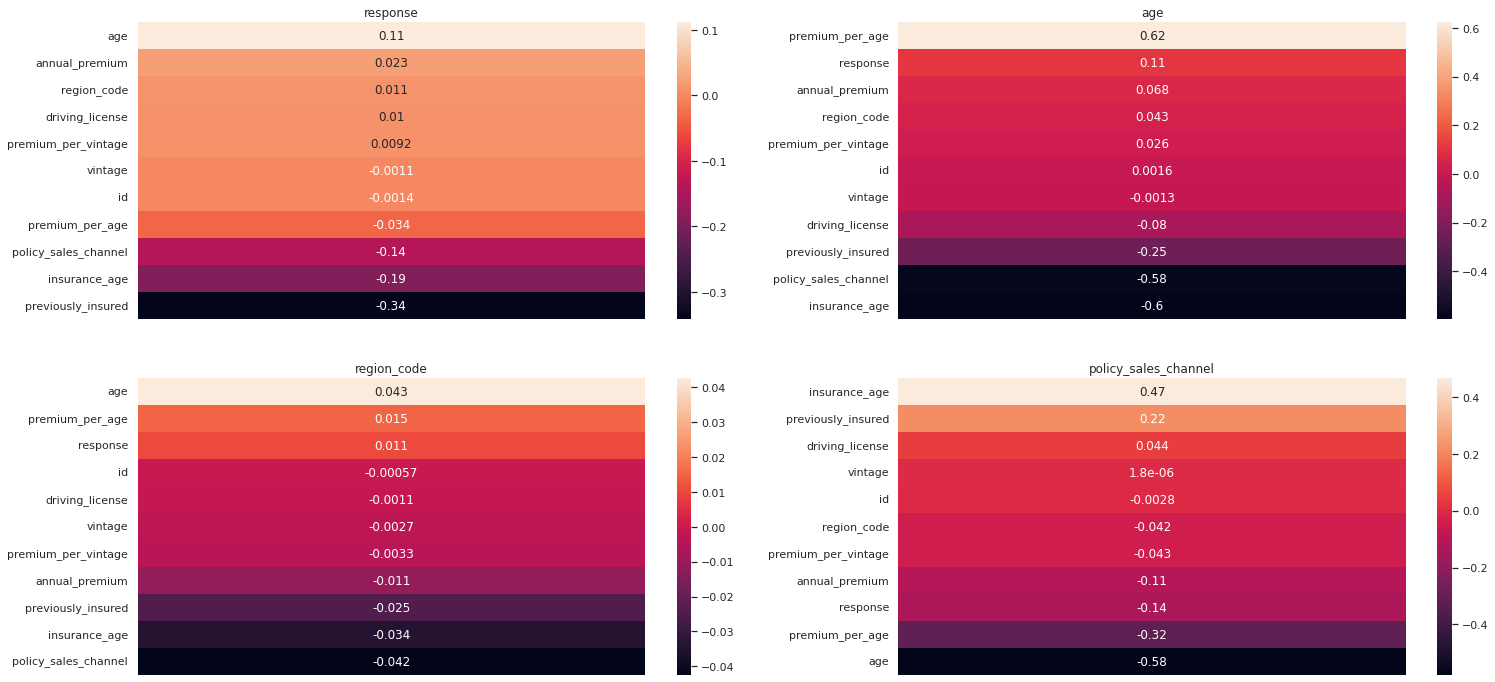

In [47]:
# creating subplots
fig, ax = plt.subplots()

plt.subplot(2, 2, 1)
correlation_ascending(df3, 'response', 'pearson');

plt.subplot(2, 2, 2)
correlation_ascending(df3, 'age', 'pearson');

plt.subplot(2, 2, 3)
correlation_ascending(df3, 'region_code', 'pearson');

plt.subplot(2, 2, 4)
correlation_ascending(df3, 'policy_sales_channel', 'pearson');


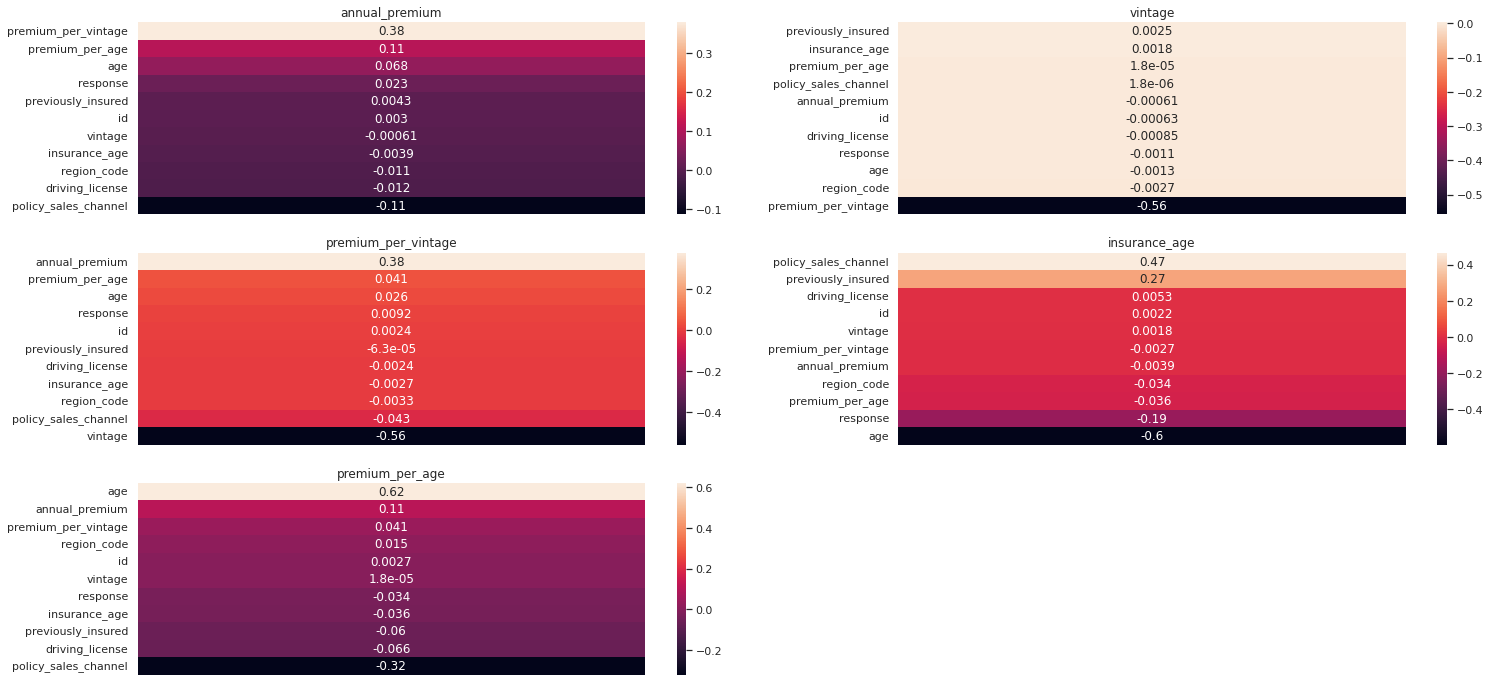

In [48]:
# creating subplots
fig, ax = plt.subplots()

plt.subplot(3, 2, 1)
correlation_ascending(df3, 'annual_premium', 'pearson');

plt.subplot(3, 2, 2)
correlation_ascending(df3, 'vintage', 'pearson');

plt.subplot(3, 2, 3)
correlation_ascending(df3, 'premium_per_vintage', 'pearson');

plt.subplot(3, 2, 4)
correlation_ascending(df3, 'insurance_age', 'pearson');

plt.subplot(3, 2, 5)
correlation_ascending(df3, 'premium_per_age', 'pearson');

#### 3.4.2 Categorical Features

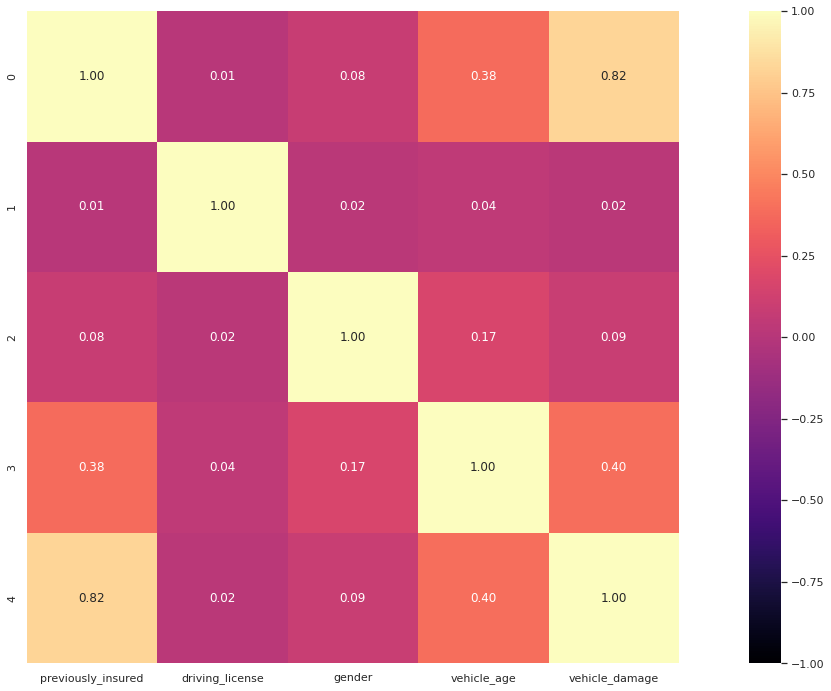

In [49]:
cat_features = df3[['previously_insured', 'driving_license', 'gender', 'vehicle_age', 'vehicle_damage']]
cat_corr = pd.DataFrame(cramers_v(cat_features))
sns.heatmap(cat_corr, fmt = '.2f', vmin = -1, vmax = 1, annot = True, cmap = 'magma', square = True);

### 3.5 Save State


In [50]:
df3.to_pickle(homepath + 'data/processed/df3.pkl')

## 4. DATA PREPARATION

### 4.1 Dataset Checkpoint


In [51]:
x_train = pd.read_pickle(homepath + 'data/processed/x_train.pkl')
x_test =  pd.read_pickle(homepath + 'data/processed/x_test.pkl')
x_val = pd.read_pickle(homepath + 'data/processed/x_val.pkl')

for dataframe in [x_train, x_test, x_val]:
    dataframe.drop(columns = ['id'], inplace = True)

In [133]:
train_test_val_diff = plot_diff([x_train, x_test, x_val])
train_test_val_diff.save(homepath + 'reports/df_diff')
train_test_val_diff.show_browser()

Opening in existing browser session.


[48144:48144:0100/000000.629077:ERROR:sandbox_linux.cc(374)] InitializeSandbox() called with multiple threads in process gpu-process.


In [52]:
# target: response
y_train, y_test, y_val = [dataframe['response'] for dataframe in [x_train, x_test, x_val]]
X_train, X_test, X_val = [dataframe.drop(columns = ['response']) for dataframe in [x_train, x_test, x_val]]

### 4.2 Encoding

In [53]:
# One Hot Encoding in 'vehicle_age', 'gender' and 'vehicle_damage'
# Frequency Encoding in 'policy_sales_channel', 'region_code'
gender_encoding = {'Male': 0, 'Female': 1}
question_encoding = {'No': 0, 'Yes': 1}
fe_cols = ['policy_sales_channel', 'region_code'] 

X_train, X_test, X_val = [pd.get_dummies(dataframe, prefix = ['car_age'],columns = ['vehicle_age']) for dataframe in [X_train, X_test, X_val]]

for dataframe in [X_train, X_test, X_val]:
    dataframe['gender'] = dataframe['gender'].map(gender_encoding)
    dataframe['vehicle_damage'] = dataframe['vehicle_damage'].map(question_encoding)
    
    
for col_name in fe_cols:
    fe_train, fe_test, fe_val = [(dataframe.groupby(col_name).size())/len(dataframe) for dataframe in [X_train, X_test, X_val]]
    X_train.loc[:, col_name] = X_train[col_name].map(fe_train)
    X_test.loc[:, col_name] = X_test[col_name].map(fe_test)
    X_val.loc[:, col_name] = X_val[col_name].map(fe_val)

### 4.3 Rescaling

1. Without Outlier and With Normal Distribution: Standard Scaler (Mean and std deviation)
2. With Outliers and Normal Distribution: Robust Scaler (Quartile)
3. Without Normal Distribution: MinMax Scaler

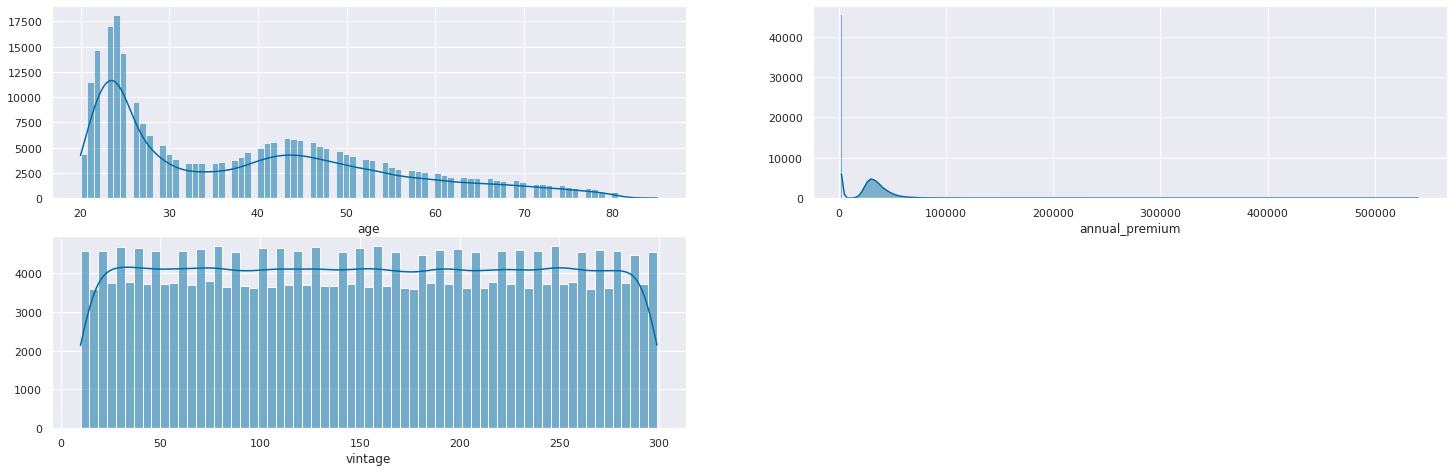

In [54]:
multiple_histplots(X_train[['age', 'annual_premium','vintage']], 3, 2);

In [55]:
# Min-Max Scaler
mms = MinMaxScaler()
rs = RobustScaler()

min_max_scaler = ['age', 'vintage']
robust_scaler = ['annual_premium']

for col in min_max_scaler:
    X_train[[col]] = mms.fit_transform(X_train[[col]].values)
    X_test[col] = mms.fit_transform(X_test[[col]].values)
    X_val[col] = mms.fit_transform(X_val[[col]].values)

for col in robust_scaler:
    X_train[[col]] = rs.fit_transform(X_train[[col]].values)
    X_test[col] = rs.fit_transform(X_test[[col]].values)
    X_val[col] = rs.fit_transform(X_val[[col]].values)

### 4.4 Feature Importance

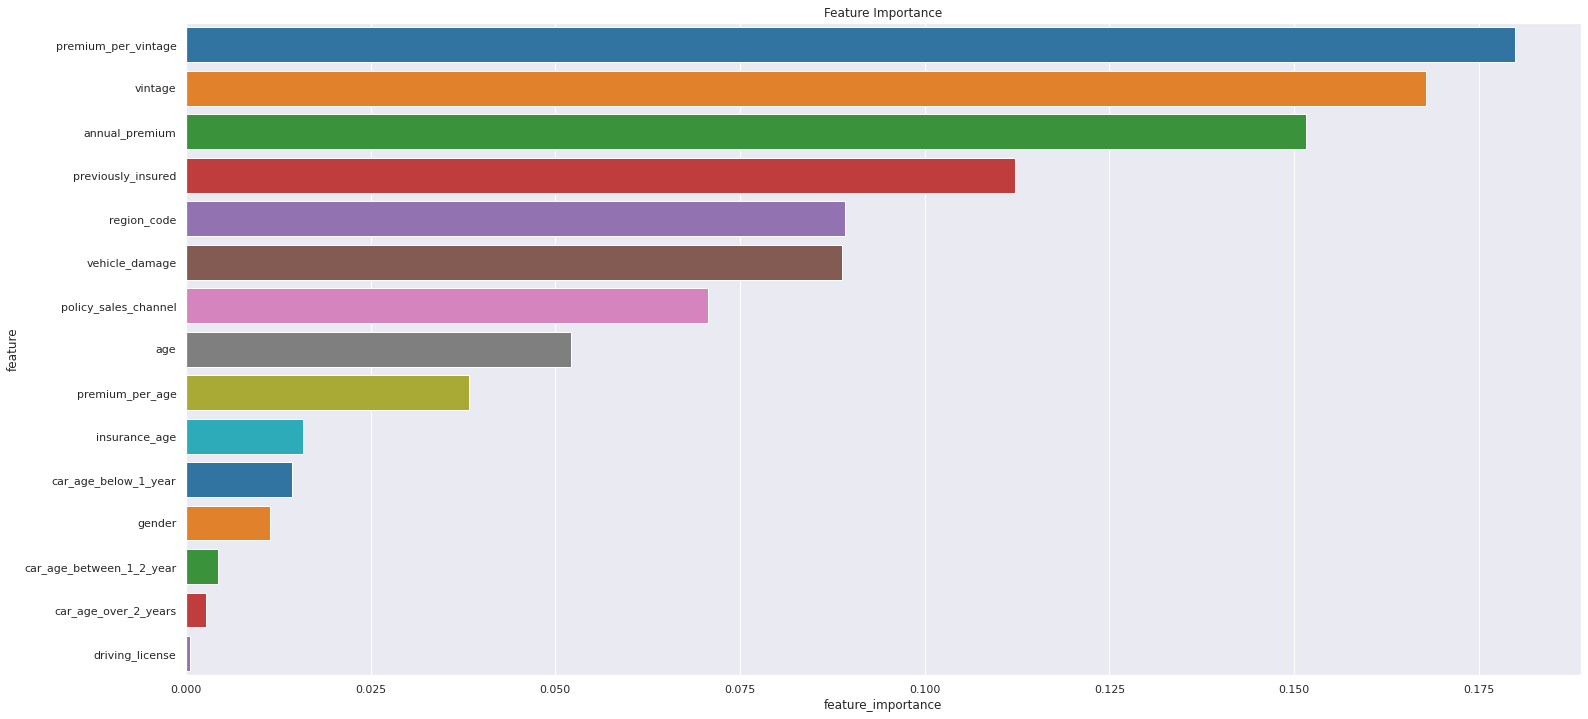

In [56]:
# train random forest
rf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = seed)
rf.fit(X_train, y_train)

# feature importance data frame
feature_selection = pd.DataFrame({'feature': X_train.columns,'feature_importance': rf.feature_importances_})\
                                .sort_values('feature_importance', ascending = False).reset_index(drop = True)

# plot feature importance
ax = sns.barplot(x = 'feature_importance', y = 'feature', data = feature_selection, orient = 'h', palette = 'tab10')
ax.set_title('Feature Importance');

### 4. Save State


## 5. MACHINE LEARNING MODELLING

In [ ]:
# model definition
lr = LogisticRegression(random_state = seed, solver = 'lbfgs', max_iter = 1000)

# model training
lr.fit(X_train, y_train)

# model predictionb
yhat_lr = lr.predict_proba(X_val)

In [ ]:
# model definition
rf = RandomForestClassifier(random_state = seed)

# model training
rf.fit(X_train, y_train)

# model prediction
yhat_rf = rf.predict_proba(X_val)

In [ ]:
models = [lr, rf]
model_metrics(models, X_val, y_val)

## 6. HYPERPARAMETER FINE TUNNING

## 7. TUNNED MODEL PERFORMANCE

## 8. BUSINESS TRANSLATION